In [3]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd


# important links 
# Find platform https://www.ncbi.nlm.nih.gov/geo/browse/?view=platforms&tool=findplatform
# GEO DataSets (query by GSE) https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174743
# GEO DataSets (query by searching terms) https://www.ncbi.nlm.nih.gov/gds


### Data structure prompt 

In [ ]:

# My DataFrame is called `df_combined`.  
# It contains the following columns:

# - **Series**: Dataset identifier/group.
# - **Samples**: Number of samples in each Series.
# - **File type/resource**: File type or extension (may include .gz or other compressed extensions).
# - **Supplementary file**: File name or path.
# - **Size**: File size as a string (e.g., '1.6 Gb', '4.5 Mb').
# - **Platforms**: Platform(s) used, sometimes comma-separated (e.g., 'GPL19057', 'GPL11154, GPL13112').
# - (Add any other columns here if relevant!)

# When I ask questions or request visualizations, please:
# - Always convert "Size" to MB for calculations/plots.
# - Treat ".gz" files as their uncompressed file type (e.g., ".fastq.gz" becomes ".fastq").
# - Recognize that "Platforms" may contain multiple IDs in a single string. If so, treat as "Multiple Platforms" for coloring.
# - For network graphs, use the last 30% of "Supplementary file" strings for similarity analysis.
# - Allow me to filter by any column, like Platforms, Series, etc.
# - Provide code and visualizations in Python (pandas, matplotlib, seaborn, networkx, etc.).

# If I ask for summaries, plots, or networks, please use these conventions unless I specify otherwise.


In [8]:
df_combined = pd.read_csv(r"C:\Users\jwilso09\OneDrive - St. Jude Children's Research Hospital\Documents\GEO_app\objects\geo_webscrap.csv")

In [9]:
df_combined['Series'].value_counts()

Series
GSE261348    37
GSE261345    31
GSE168233    29
GSE216069    15
GSE235675    11
             ..
GSE285327     1
GSE285328     1
GSE285332     1
GSE285341     1
GSE291687     1
Name: count, Length: 80, dtype: int64

Total Size (MB): 14940.45
Number of Samples: 40
Number of different file types: 5
Number of unique supplementary files: 29


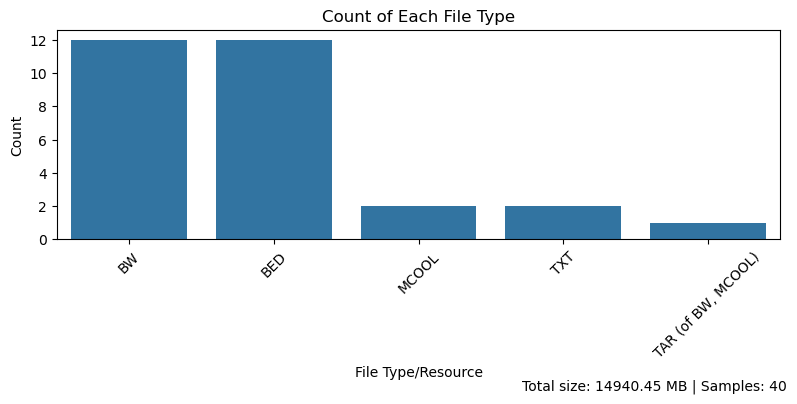

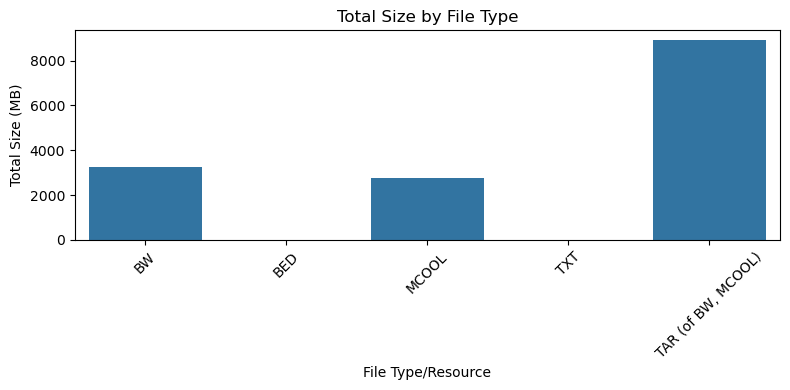

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper function to convert size strings to MB
def size_to_mb(size_str):
    if pd.isnull(size_str):
        return 0
    size_str = str(size_str).strip()
    if not size_str:
        return 0
    try:
        num, unit = size_str.split()
        num = float(num)
        unit = unit.lower()
        if unit.startswith('gb'):
            return num * 1024
        elif unit.startswith('mb'):
            return num
        elif unit.startswith('kb'):
            return num / 1024
        elif unit.startswith('b'):
            return num / (1024 * 1024)
        else:
            return None
    except Exception:
        return None

# Convert 'Size' to MB for all rows
df_combined['Size_MB'] = df_combined['Size'].apply(size_to_mb)

series_val = "GSE168233"  # replace as needed
df_series = df_combined[df_combined["Series"] == series_val]

# Use Size_MB instead of Size
total_size = df_series["Size_MB"].sum()
samples = df_series["Samples"].iloc[0]
num_file_types = df_series["File type/resource"].nunique()
num_files = df_series["Supplementary file"].nunique()

print(f"Total Size (MB): {total_size:.2f}")
print(f"Number of Samples: {samples}")
print(f"Number of different file types: {num_file_types}")
print(f"Number of unique supplementary files: {num_files}")

# Visualization: File Type Counts
plt.figure(figsize=(8, 4))
sns.countplot(data=df_series, x="File type/resource", order=df_series["File type/resource"].value_counts().index)
plt.title('Count of Each File Type')
plt.xlabel('File Type/Resource')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.figtext(0.99, 0.01, f"Total size: {total_size:.2f} MB | Samples: {samples}", horizontalalignment='right')
plt.tight_layout()
plt.show()

# Visualization: Size by File Type (using Size_MB)
plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_series.groupby("File type/resource")["Size_MB"].sum().reset_index(),
    x="File type/resource", y="Size_MB", order=df_series["File type/resource"].value_counts().index
)
plt.title('Total Size by File Type')
plt.xlabel('File Type/Resource')
plt.ylabel('Total Size (MB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== Dataset Summary by Series ===
       Series  total_size_mb  num_samples  num_file_types  num_files
0   GSE112996            5.6           45               1          1
1   GSE114989         1102.0           40               2          2
2   GSE122688          343.8           70               1          1
3   GSE122689         1228.8            2               1          1
4   GSE146161         2867.2           36               1          1
..        ...            ...          ...             ...        ...
75  GSE291687          320.0            2               1          1
76   GSE40407         1638.4          391               1          1
77   GSE48568         1433.6          129               1          1
78   GSE59620            4.5           12               1          1
79   GSE94758           55.0           72               1          2

[80 rows x 5 columns]

=== File Type Breakdown by Series ===
File type/resource  BED  BW  CSV  MCOOL  MTX  PKC  PNG  TAR  \
Series       

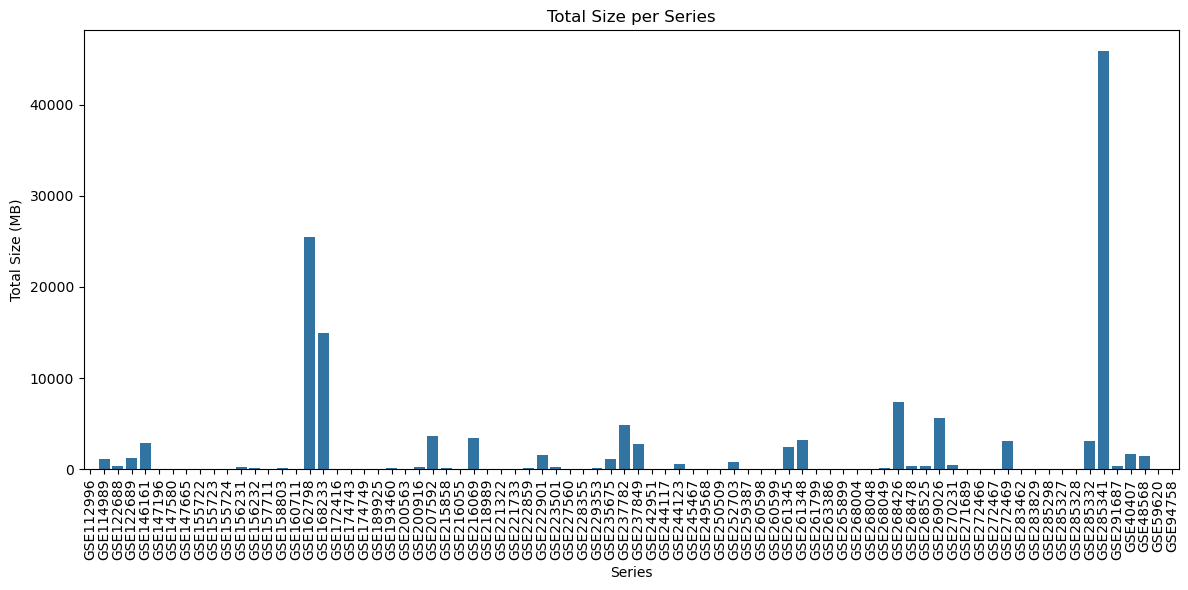

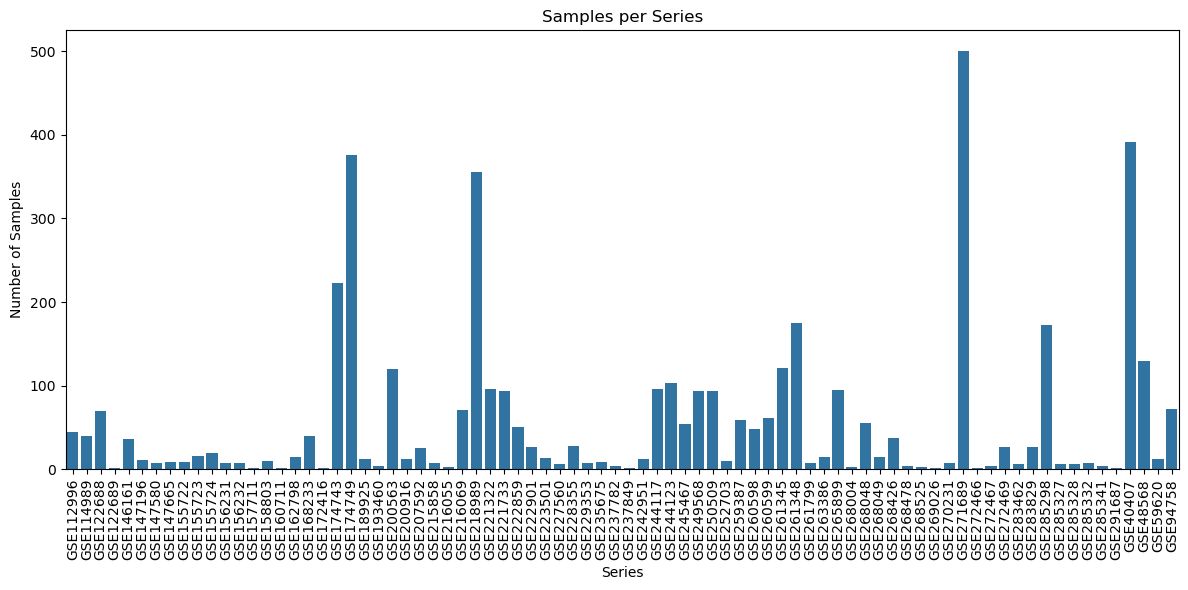

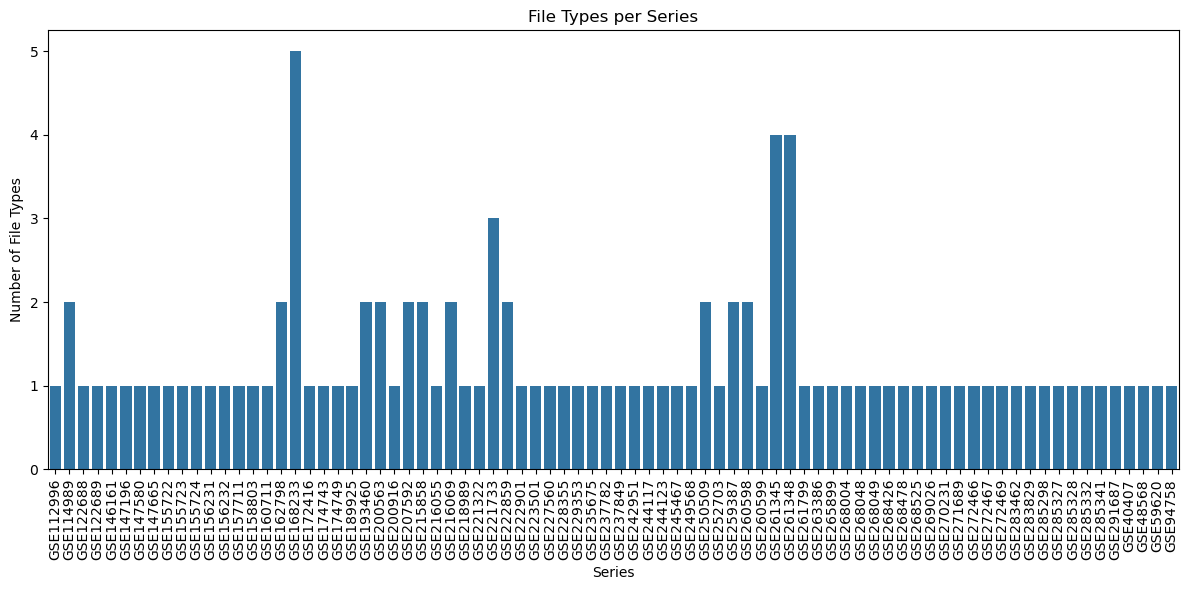

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Helper function to convert size strings to MB ---
def size_to_mb(size_str):
    if pd.isnull(size_str):
        return 0
    size_str = str(size_str).strip()
    if not size_str:
        return 0
    try:
        num, unit = size_str.split()
        num = float(num)
        unit = unit.lower()
        if unit.startswith('gb'):
            return num * 1024
        elif unit.startswith('mb'):
            return num
        elif unit.startswith('kb'):
            return num / 1024
        elif unit.startswith('b'):
            return num / (1024 * 1024)
        else:
            return None
    except Exception:
        return None

# --- 2. Apply conversion to entire DataFrame ---
df_combined['Size_MB'] = df_combined['Size'].apply(size_to_mb)

# --- 3. Compile summary for each Series ---
summary = (
    df_combined
    .groupby('Series')
    .agg(
        total_size_mb=('Size_MB', 'sum'),
        num_samples=('Samples', 'first'),  # Assuming all rows in a Series have the same value
        num_file_types=('File type/resource', 'nunique'),
        num_files=('Supplementary file', 'nunique')
    )
    .reset_index()
)

print("=== Dataset Summary by Series ===")
print(summary)

# --- 4. Optional: File type breakdown per Series ---
file_type_counts = (
    df_combined
    .groupby(['Series', 'File type/resource'])
    .size()
    .unstack(fill_value=0)
)

print("\n=== File Type Breakdown by Series ===")
print(file_type_counts)

# --- 5. Optional: Visualize summary ---
plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='Series', y='total_size_mb')
plt.xticks(rotation=90)
plt.ylabel('Total Size (MB)')
plt.title('Total Size per Series')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='Series', y='num_samples')
plt.xticks(rotation=90)
plt.ylabel('Number of Samples')
plt.title('Samples per Series')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='Series', y='num_file_types')
plt.xticks(rotation=90)
plt.ylabel('Number of File Types')
plt.title('File Types per Series')
plt.tight_layout()
plt.show()

       Series  total_size_mb  num_samples  num_file_types  num_files Platforms
0   GSE112996            5.6           45               1          1  GPL20795
1   GSE114989         1102.0           40               2          2  GPL21145
2   GSE122688          343.8           70               1          1  GPL20301
3   GSE122689         1228.8            2               1          1  GPL20301
4   GSE146161         2867.2           36               1          1  GPL28205
..        ...            ...          ...             ...        ...       ...
75  GSE291687          320.0            2               1          1  GPL34290
76   GSE40407         1638.4          391               1          1   GPL6244
77   GSE48568         1433.6          129               1          1  GPL11068
78   GSE59620            4.5           12               1          1  GPL18982
79   GSE94758           55.0           72               1          2  GPL17543

[80 rows x 6 columns]


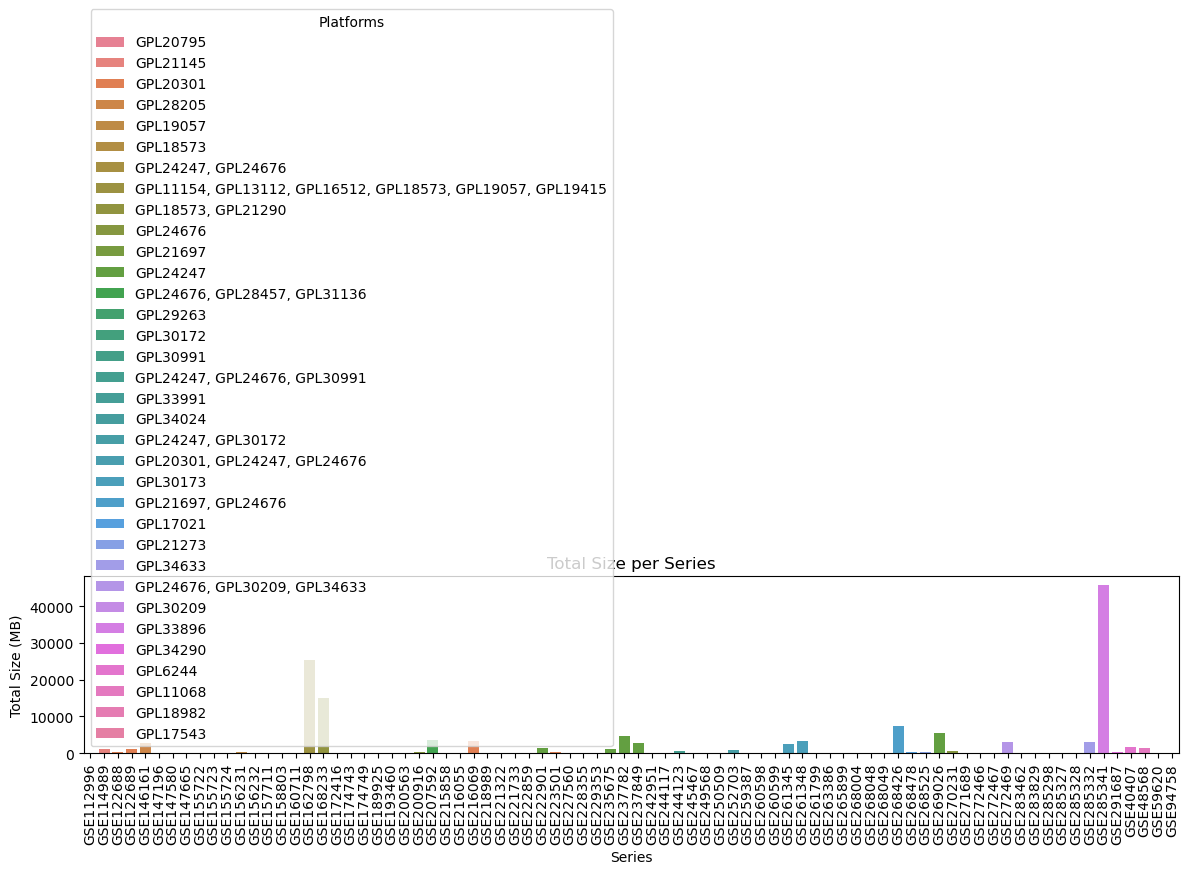

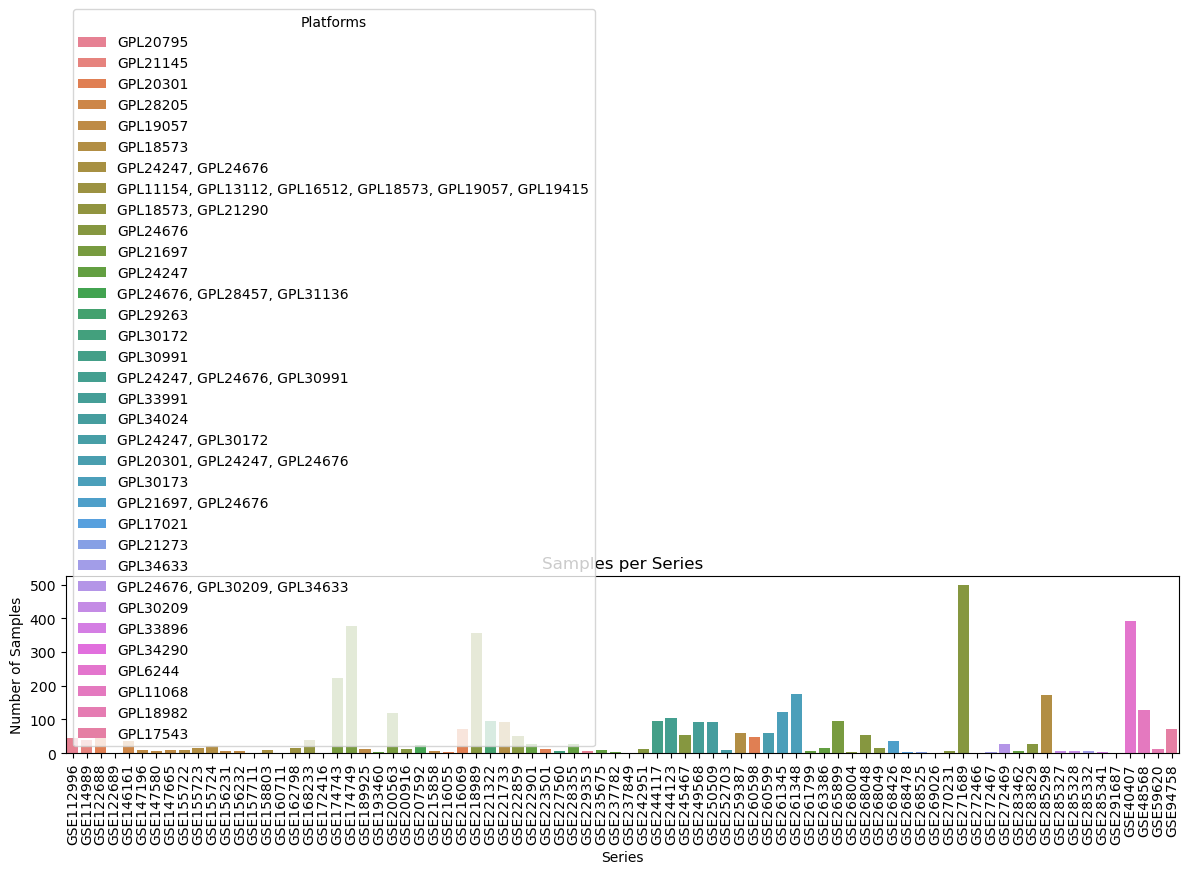

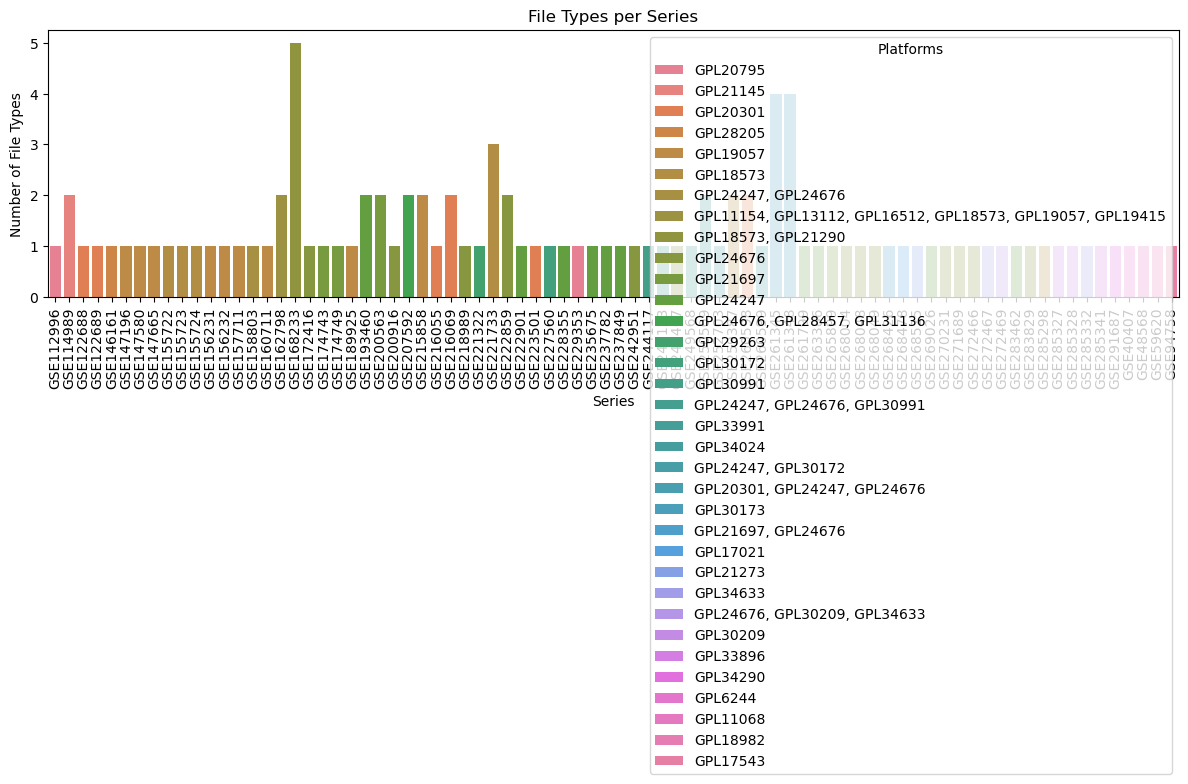

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def size_to_mb(size_str):
    if pd.isnull(size_str):
        return 0
    size_str = str(size_str).strip()
    if not size_str:
        return 0
    try:
        num, unit = size_str.split()
        num = float(num)
        unit = unit.lower()
        if unit.startswith('gb'):
            return num * 1024
        elif unit.startswith('mb'):
            return num
        elif unit.startswith('kb'):
            return num / 1024
        elif unit.startswith('b'):
            return num / (1024 * 1024)
        else:
            return None
    except Exception:
        return None

df_combined['Size_MB'] = df_combined['Size'].apply(size_to_mb)

summary = (
    df_combined
    .groupby('Series')
    .agg(
        total_size_mb=('Size_MB', 'sum'),
        num_samples=('Samples', 'first'),
        num_file_types=('File type/resource', 'nunique'),
        num_files=('Supplementary file', 'nunique'),
        Platforms=('Platforms', 'first')  # Or use lambda if multiple platforms per Series
    )
    .reset_index()
)

print(summary)

plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='Series', y='total_size_mb', hue='Platforms')
plt.xticks(rotation=90)
plt.ylabel('Total Size (MB)')
plt.title('Total Size per Series')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='Series', y='num_samples', hue='Platforms')
plt.xticks(rotation=90)
plt.ylabel('Number of Samples')
plt.title('Samples per Series')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='Series', y='num_file_types', hue='Platforms')
plt.xticks(rotation=90)
plt.ylabel('Number of File Types')
plt.title('File Types per Series')
plt.tight_layout()
plt.show()

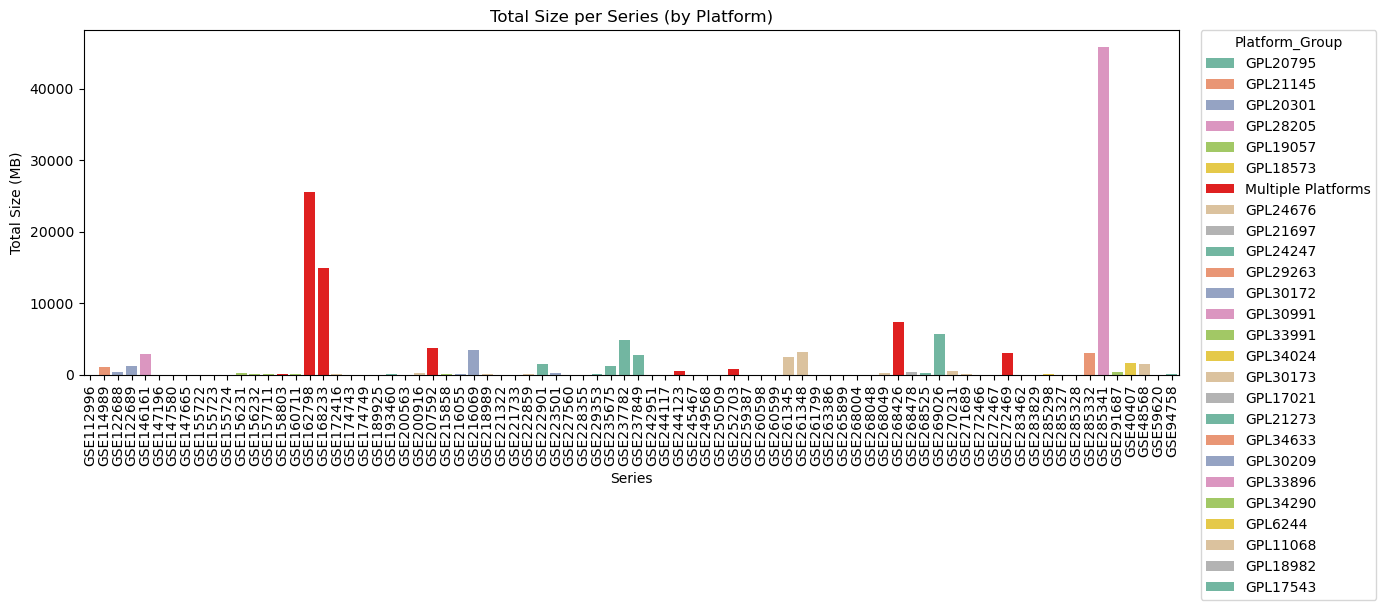

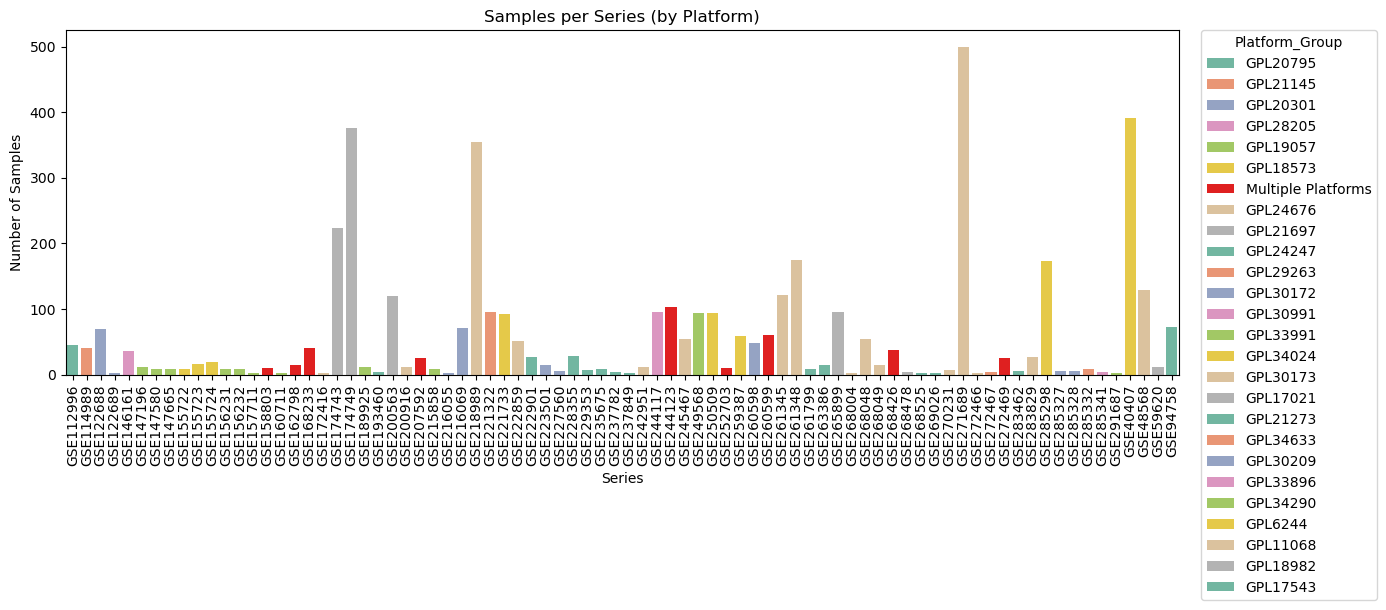

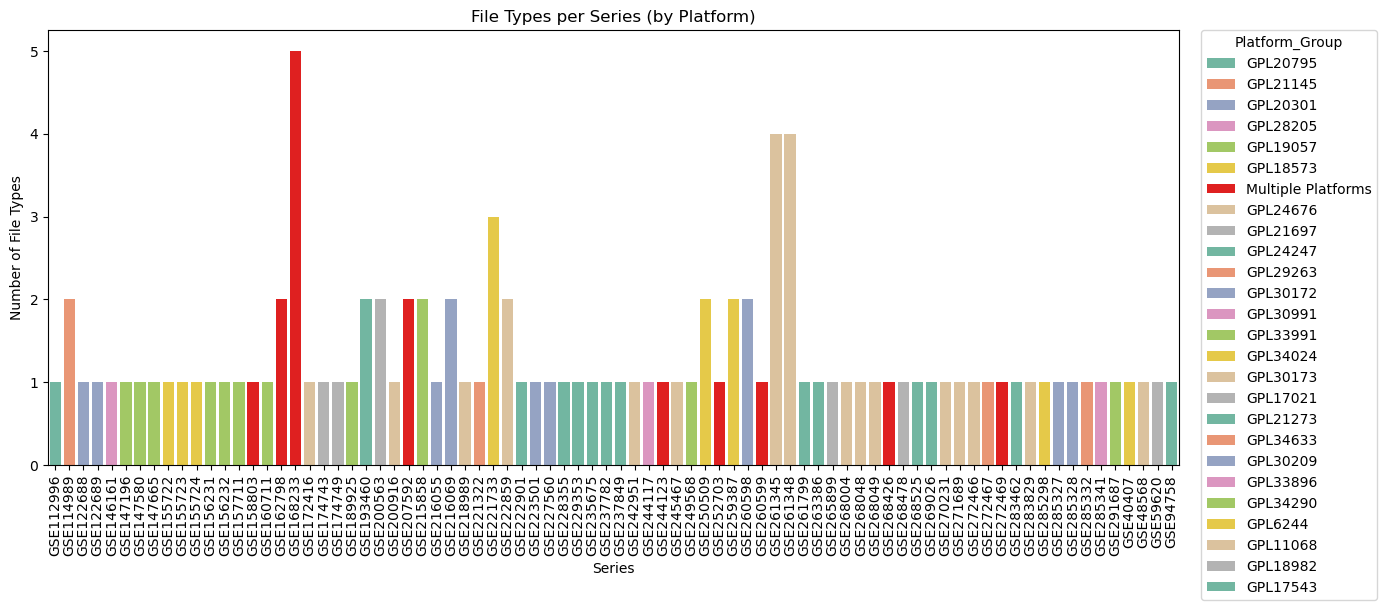

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import plotly.express as px
import textwrap

#wraps the lines of text so that only 35 characters appear per line
def wrap_text(s, width=50):
    #if there are any missing values, returns them as strings 
    if pd.isnull(s): 
        return "" 
    #returns breaks at spaces
    return "<br>".join(textwrap.wrap(s, width=width, break_long_words=False))

#Assigns specific elements/columns to have their data wrapped
summary_with_details["Title_wrapped"] = summary_with_details["Title"].apply(lambda x: wrap_text(x, 50)) 


#(Plot 1) This converts string sizes to MB
def size_to_mb(size_str):
    if pd.isnull(size_str):
        return 0
    size_str = str(size_str).strip()
    if not size_str:
        return 0
    try:
        num, unit = size_str.split()
        num = float(num)
        unit = unit.lower()
        if unit.startswith('gb'):
            return num * 1024
        elif unit.startswith('mb'):
            return num
        elif unit.startswith('kb'):
            return num / 1024
        elif unit.startswith('b'):
            return num / (1024 * 1024)
        else:
            return None
    except Exception:
        return None

#This normalizes files, and removes ".gz" where nessisary
def unzipped_filetype(filetype):
    if pd.isnull(filetype):
        return filetype
    filetype = str(filetype).strip()
    if filetype.endswith('.gz') and not filetype.endswith('.tar.gz'):
        return filetype[:-3]
    return filetype

#Adds dervied collumns to the dataframe (Size_MB and Filetype_unzipped)
df_combined['Size_MB'] = df_combined['Size'].apply(size_to_mb)
df_combined['Filetype_unzipped'] = df_combined['File type/resource'].apply(unzipped_filetype)

#Creates the grouped summary per series
summary = (
    df_combined
    .groupby('Series')
    .agg(
        total_size_mb=('Size_MB', 'sum'),
        num_samples=('Samples', 'first'),
        num_file_types=('Filetype_unzipped', 'nunique'),
        num_files=('Supplementary file', 'nunique'),
        Platforms=('Platforms', 'first')
    )
    .reset_index()
)

#Platform grouping and pallet
def platform_group(platform_str):
    if pd.isnull(platform_str):
        return 'Unknown'
    platforms = [p.strip() for p in str(platform_str).split(',')]
    if len(platforms) > 1:
        return 'Multiple Platforms'
    else:
        return platforms[0]

summary['Platform_Group'] = summary['Platforms'].apply(platform_group)

platform_groups = summary['Platform_Group'].unique()
colors = sns.color_palette('Set2', len(platform_groups))
palette = {}
color_iter = iter(colors)
for pg in platform_groups:
    if pg == 'Multiple Platforms':
        palette[pg] = 'red'
    else:
        palette[pg] = next(color_iter)


#Plotting helper: plot_with_outside_legend
def plot_with_outside_legend(data, x, y, hue, palette, ylabel, title):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, palette=palette)
    plt.xticks(rotation=90)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.legend(
        title=hue,
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0.
    )
    plt.show()

##Actually plotting, plots
plot_with_outside_legend(
    summary, 'Series', 'total_size_mb', 'Platform_Group', palette,
    ylabel='Total Size (MB)', title='Total Size per Series (by Platform)'
)

plot_with_outside_legend(
    summary, 'Series', 'num_samples', 'Platform_Group', palette,
    ylabel='Number of Samples', title='Samples per Series (by Platform)'
)

plot_with_outside_legend(
    summary, 'Series', 'num_file_types', 'Platform_Group', palette,
    ylabel='Number of File Types', title='File Types per Series (by Platform)'
)

In [99]:
#Interactive bar graph
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import textwrap


#To create the hover_data (merge Title from df_combined into summary)
extra_info = (
    df_combined
    .groupby("Series")
    .agg({"Title": "first"})
    .reset_index()
)
summary_with_details = summary.merge(extra_info, on="Series", how="left")

#wraps the lines of text so that only 35 characters appear per line
def wrap_text(s, width=50):
    #if there are any missing values, returns them as strings 
    if pd.isnull(s): 
        return "" 
    #returns breaks at spaces
    return "<br>".join(textwrap.wrap(s, width=width, break_long_words=False))

#Assigns specific elements/columns to have their data wrapped
summary_with_details["Title_wrapped"] = summary_with_details["Title"].apply(lambda x: wrap_text(x, 50)) 

#Figure 1: Series v. Total Size (MB)
fig1 = px.bar(
    summary_with_details,
    x="Series",
    y="total_size_mb",
    color="Platform_Group",
    hover_data={
        "Series": True,
        "total_size_mb": True,
        "num_samples": True,
        "num_file_types": True,
        "Title_wrapped": True
    },
    title="Total Size per Series (by Platform)",
    width=1000,
    height=600
)

fig1.update_layout(
    xaxis_title="Series",
    yaxis_title="Total Size (MB)",
    legend_title="Platform",
    plot_bgcolor="white",
    xaxis=dict(
        showline=True,      # show axis line
        linecolor="black",  # axis line color
        ticks="outside"     # put ticks outside plot
        ),
    yaxis=dict(
        showline=True,
        linecolor="black",
        ticks="outside"
        )
)

#Figure 2: Series v. Number of Samples
fig2 = px.bar(
    summary_with_details,
    x="Series",
    y="num_samples",
    color="Platform_Group",
    hover_data={
        "Series": True,
        "total_size_mb": True,
        "num_samples": True,
        "num_file_types": True,
        "Title_wrapped": True
    },
    title="Samples per Series (by Platform)",
    width=1000,
    height=600
)

fig2.update_layout(
    xaxis_title="Series",
    yaxis_title="Number of Samples",
    legend_title="Platform",
    plot_bgcolor="white",
    xaxis=dict(
        showline=True,      # show axis line
        linecolor="black",  # axis line color
        ticks="outside"     # put ticks outside plot
        ),
    yaxis=dict(
        showline=True,
        linecolor="black",
        ticks="outside"
        )
)

#Figure 3: Series v. Number of File Types
fig3 = px.bar(
    summary_with_details,
    x="Series",
    y="num_file_types",
    color="Platform_Group",
    hover_data={
        "Series": True,
        "total_size_mb": True,
        "num_samples": True,
        "num_file_types": True,
        "Title_wrapped": True
    },
    title="Total Amount of File Types per Series (by Platform)",
    width=1000,
    height=600
)

fig3.update_layout(
    xaxis_title="Series",
    yaxis_title="Number of Files",
    legend_title="Platform",
    plot_bgcolor="white",
    xaxis=dict(
        showline=True,      # show axis line
        linecolor="black",  # axis line color
        ticks="outside"     # put ticks outside plot
        ),
    yaxis=dict(
        showline=True,
        linecolor="black",
        ticks="outside"
        )
)

fig1.show()
fig2.show()
fig3.show()

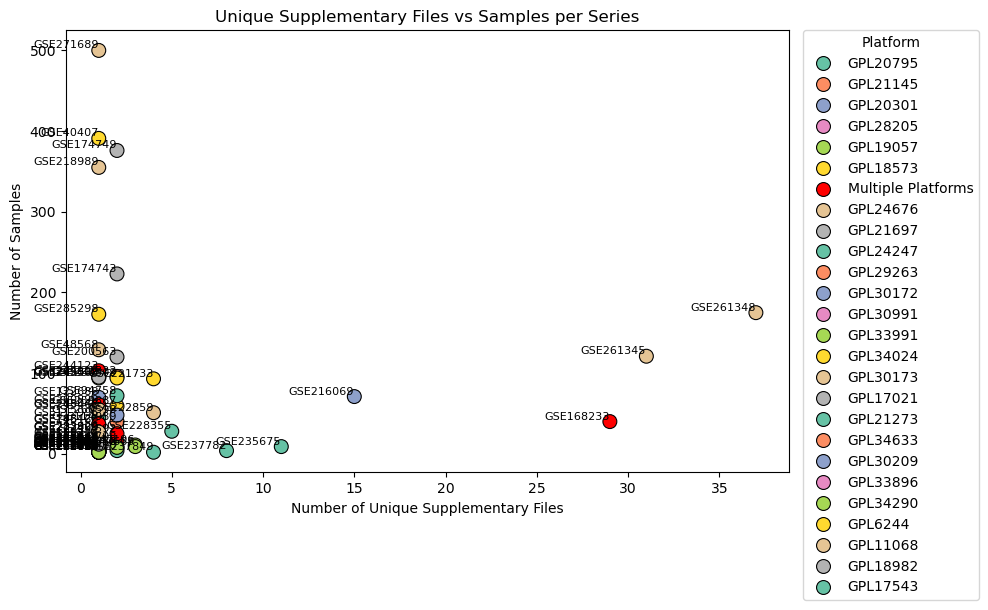

In [ ]:
# Shows complexity - if a GSE has 100 samples but just 1 file type, it means the submission is messy 
# We should add the "year of plubication" to this at some point  
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=summary,
    x='num_files',              # Number of unique Supplementary files per Series
    y='num_samples',            # Number of Samples per Series (not summed, just the value)
    hue='Platform_Group',       # Color by Platform_Group
    palette=palette,
    s=100,                      # Dot size
    edgecolor='k'
)

# Optional: label each point with its Series name
for i, row in summary.iterrows():
    ax.text(row['num_files'], row['num_samples'], row['Series'], fontsize=8, ha='right', va='bottom')

plt.xlabel('Number of Unique Supplementary Files')
plt.ylabel('Number of Samples')
plt.title('Unique Supplementary Files vs Samples per Series')
plt.legend(
    title='Platform',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()

In [82]:
#Make more similar to plot above 
import plotly.express as px
import textwrap

#wraps the lines of text so that only 35 characters appear per line
def wrap_text(s, width=50):
    #if there are any missing values, returns them as strings 
    if pd.isnull(s): 
        return "" 
    #returns breaks at spaces
    return "<br>".join(textwrap.wrap(s, width=width, break_long_words=False))

#Assigns specific elements/columns to have their data wrapped
summary_with_details["Title_wrapped"] = summary_with_details["Title"].apply(lambda x: wrap_text(x, 50)) 

#Creates a scatterplot
fig = px.scatter( 
    summary_with_details, 
    x="num_files", 
    y="num_samples", 
    #What appears in the legend
    color="Platform_Group",
    #Labels the dot
    text="Series",
    #Data that appears when hovering over 
    hover_data={  
        "total_size_mb": True, 
        "Title_wrapped": True, 
        },
    title="Unique Supplementary Files vs Samples per Series (with file details)",
    #figsize
    width=1000,
    height=600
)

#Style Aspects
fig.update_traces(
    marker=dict(size=12, line=dict(width=1, color="black")),
    #moves labels slightly off to the right of points
    textposition="top right", 
    #font size of text
    textfont=dict(size=9) 
        )

fig.update_layout( 
    #Axi labels
    xaxis_title="Number of Unique Supplementary Files", 
    yaxis_title="Number of Samples", 
    legend_title="Platform",
    plot_bgcolor="white",   # inside plot background
    xaxis=dict(
        showline=True,      # show axis line
        linecolor="black",  # axis line color
        ticks="outside"     # put ticks outside plot
    ),
    yaxis=dict(
        showline=True,
        linecolor="black",
        ticks="outside"
    ) 
    )

fig.show()


In [1]:
###UPDATE: code did not work because the RateLimitReach was exceeded: would not be sufficent for multiple users to acess daily


##Using the API to call a chatbot to summarize the summary of indivial platforms in 3 words

#Import Packages
import os
import pandas as pd
import re
import openai
from openai import OpenAI, DefaultHttpxClient
import httpx

# Load the GitHub token and endpoint
#this sets enviroment variable (named GITHUB_TOKEN) to the GITHUB token value
os.environ["GITHUB_TOKEN"] = "add_token_code_here"
#Retrieves the value of the enviromental variable
token = os.environ["GITHUB_TOKEN"]
print(token)

#endpoint is where the API requests will be sent to
endpoint = "https://models.github.ai/inference"
#Specify's AI model
model_name = "openai/gpt-4o-mini"

#Creates the API client object with your endpoint, token, and HTTP settings
client = OpenAI(
    base_url=endpoint,
    api_key=token,
    http_client=DefaultHttpxClient(verify=False)  # disables SSL cert verification
)

#Load your dataset
df = pd.read_csv(r"C:\Users\jwilso09\OneDrive - St. Jude Children's Research Hospital\Documents\GEO_app\objects\geo_webscrap.csv")

#Filter for unique GSE values, and create a copy
unique_gse_df = df.drop_duplicates(subset=['Series']).copy()

#Define the summarization prompt
def summarize_with_keywords(summary_text):
    prompt = f"""
    Please summarize the following text using exactly 3 keywords (comma-separated).
    Text: {summary_text}
    Output format: keyword1, keyword2, keyword3
    """
    #this calls the AIchatbot
    response = client.chat.completions.create(
        model=model_name,
        #this provides the conversation history. 1st message sets the Aibot as an assistant. 2nd message asks prompt
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        #temperature control randomness/creativity
        temperature=0.5,
        #top_p controls the diversity of responses
        top_p=1.0,
        #max_token limits the character length of response
        max_tokens=800,
    )
    #extracts the chatbot reply
    keywords = response.choices[0].message.content.strip()
    return keywords

#Applies prompt to entire filtered dataset
unique_gse_df['summary_keywords'] = unique_gse_df['Summary'].apply(summarize_with_keywords)

# Save the DataFrame to a new CSV file
unique_gse_df.to_csv('summarized_keywords_output.csv', index=False)
print('summarized_keywords_output.cvs')

add_token_code_here


AuthenticationError: Unauthorized

In [18]:
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


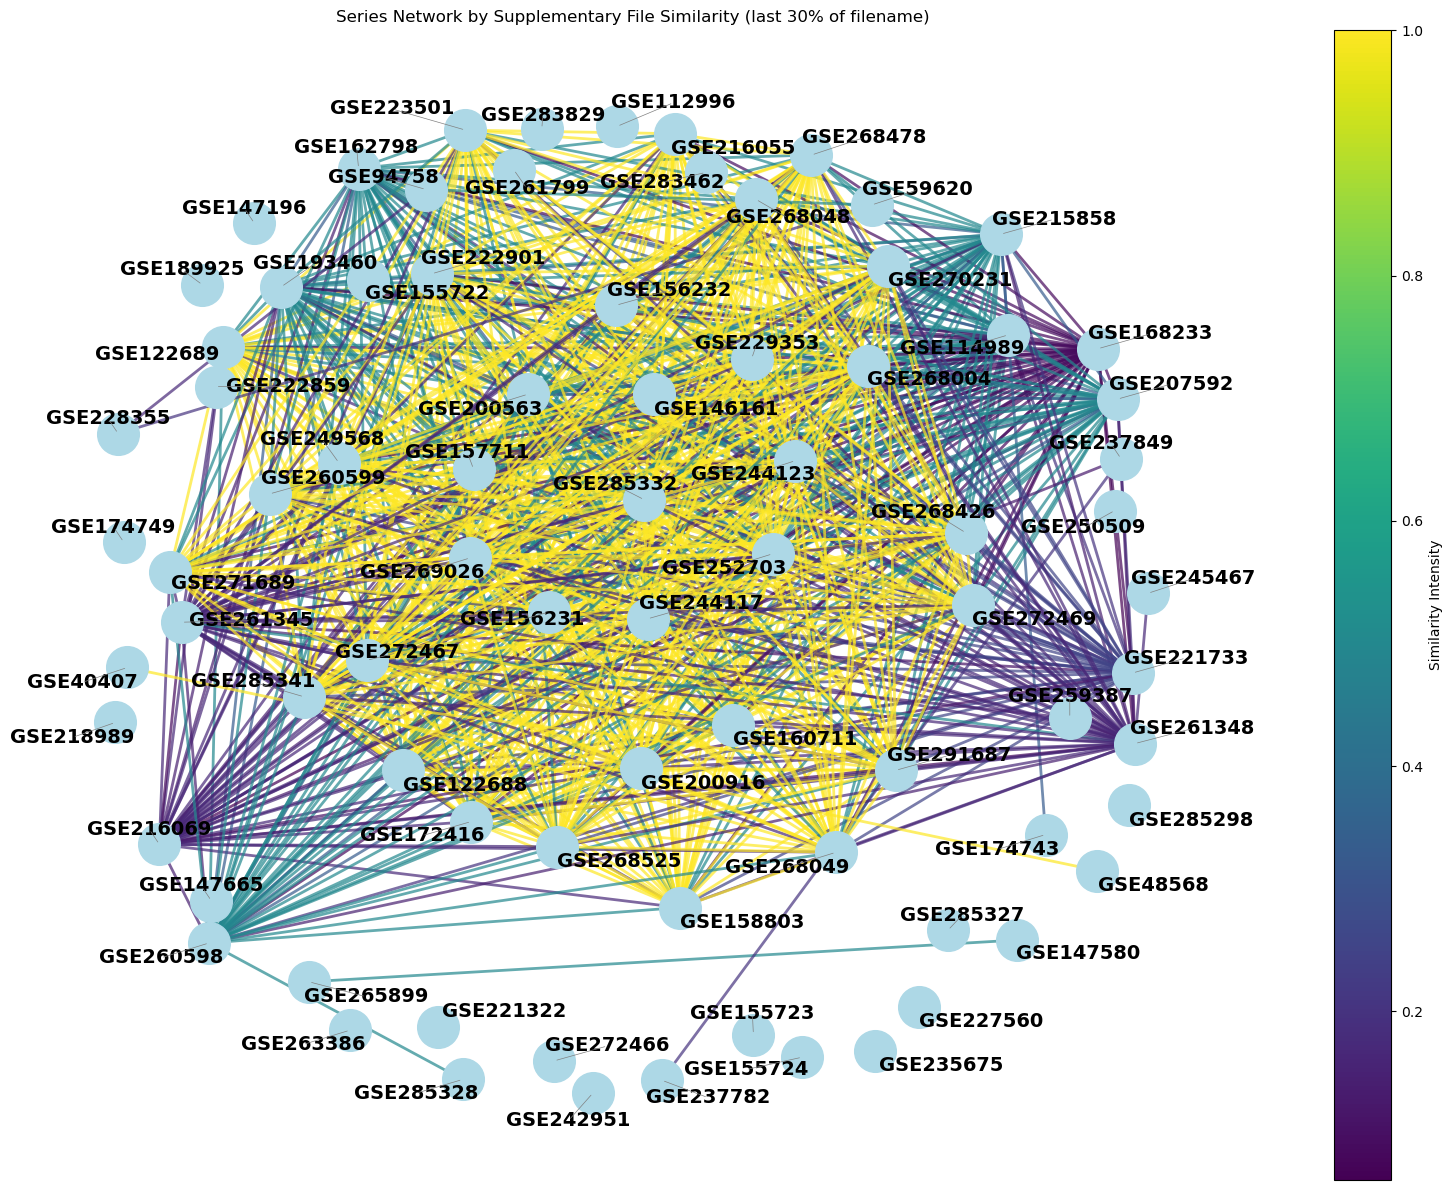

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from adjustText import adjust_text

def last_30pct(s):
    if pd.isnull(s):
        return ''
    s = str(s)
    n = max(1, int(len(s) * 0.3))
    return s[-n:]

series_files = (
    df_combined
    .groupby('Series')['Supplementary file']
    .apply(lambda files: set(last_30pct(f) for f in files))
)

from itertools import combinations

edges = []
for s1, s2 in combinations(series_files.index, 2):
    set1 = series_files[s1]
    set2 = series_files[s2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        similarity = 0
    else:
        similarity = intersection / union
    if similarity > 0:  # Only keep edges with some similarity
        edges.append((s1, s2, similarity))

G = nx.Graph()
for s in series_files.index:
    G.add_node(s)
for s1, s2, sim in edges:
    G.add_edge(s1, s2, weight=sim)

plt.figure(figsize=(16, 12))
ax = plt.gca()
pos = nx.spring_layout(G, seed=42, k=2.5)  # Increase k for more spread

edges_draw = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges_draw]
weights_arr = np.array(weights)
norm_weights = (weights_arr - weights_arr.min()) / (weights_arr.max() - weights_arr.min() + 1e-10)
edge_colors = plt.cm.viridis(norm_weights)

# Draw edges first
nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors, ax=ax, alpha=0.7)
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=900, node_color='lightblue', ax=ax)

# Use adjustText for labels
texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=14, fontweight='bold', ha='center', va='center'))

adjust_text(texts, 
            expand_points=(2.5, 2.5), 
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=weights_arr.min(), vmax=weights_arr.max()))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, label='Similarity Intensity')
plt.title('Series Network by Supplementary File Similarity (last 30% of filename)')
plt.axis('off')
plt.tight_layout()
plt.show()

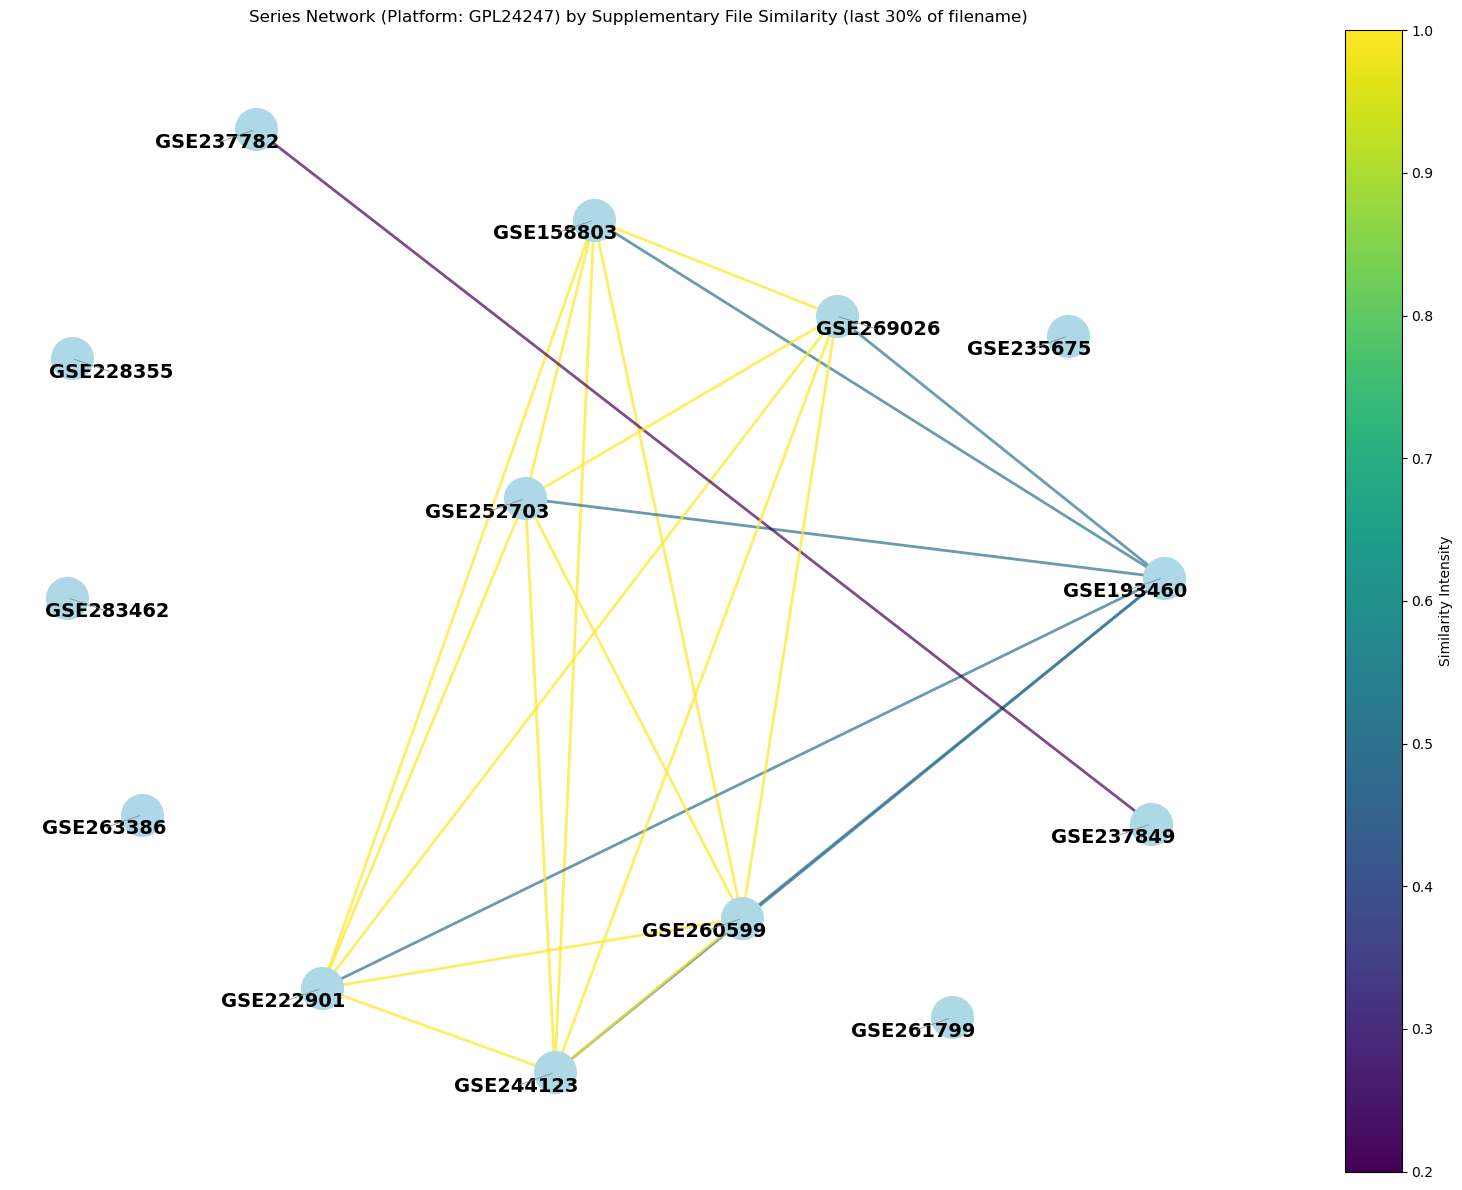

In [22]:
# Net work of file type similiarty for one technology/platform ID
# filters data set for 1 platform (file w/in dataset)
platform_filter = "GPL24247"  # <-- change to your desired platform

# Keep only rows where the platform string contains the filter
df_filtered = df_combined[df_combined['Platforms'].str.contains(platform_filter, na=False)]

#only analyze last 30% of filename
def last_30pct(s):
    if pd.isnull(s):
        return ''
    s = str(s)
    n = max(1, int(len(s) * 0.3))
    return s[-n:]

#groups data by series and convert each series into a truncated filename
series_files = (
    df_filtered
    .groupby('Series')['Supplementary file']
    .apply(lambda files: set(last_30pct(f) for f in files))
)

#Compute pairwise similarity
from itertools import combinations


edges = []
for s1, s2 in combinations(series_files.index, 2):
    set1 = series_files[s1]
    set2 = series_files[s2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        similarity = 0
    else:
        similarity = intersection / union
    if similarity > 0:
        edges.append((s1, s2, similarity))

#Build graph
G = nx.Graph()
for s in series_files.index:
    G.add_node(s)
for s1, s2, sim in edges:
    G.add_edge(s1, s2, weight=sim)

import matplotlib.pyplot as plt
from adjustText import adjust_text

#layout and draw networks
plt.figure(figsize=(16, 12))
ax = plt.gca()
pos = nx.spring_layout(G, seed=42, k=2.5)

#draw edges, nodes and labels
edges_draw = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges_draw]
weights_arr = np.array(weights)
norm_weights = (weights_arr - weights_arr.min()) / (weights_arr.max() - weights_arr.min() + 1e-10)
edge_colors = plt.cm.viridis(norm_weights)

nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors, ax=ax, alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_size=900, node_color='lightblue', ax=ax)

texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=14, fontweight='bold', ha='center', va='center'))

adjust_text(texts, 
            expand_points=(2.5, 2.5), 
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

#Add color and show plot
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=weights_arr.min(), vmax=weights_arr.max()))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, label='Similarity Intensity')
plt.title(f'Series Network (Platform: {platform_filter}) by Supplementary File Similarity (last 30% of filename)')
plt.axis('off')
plt.tight_layout()
plt.show()

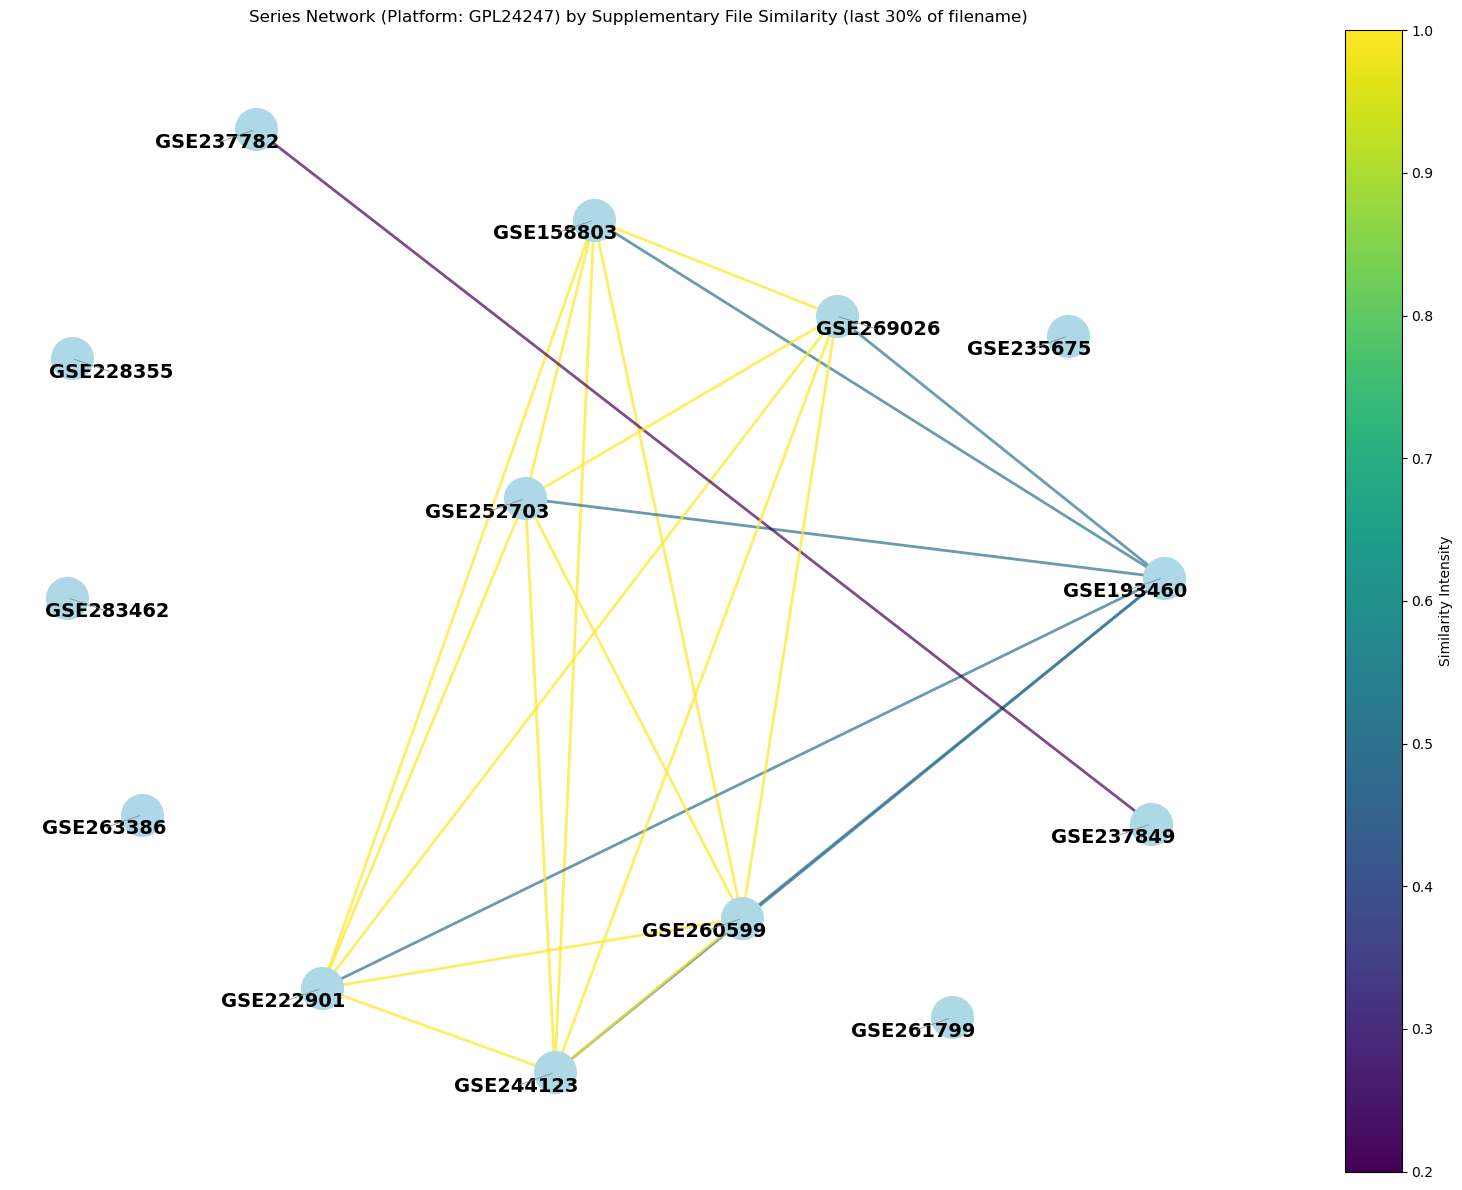

In [ ]:
# Net work of file type similiarty for one technology/platform ID
# filters data set for 1 platform (file w/in dataset)
platform_filter = "GPL24247"  # <-- change to your desired platform

# Keep only rows where the platform string contains the filter
df_filtered = df_combined[df_combined['Platforms'].str.contains(platform_filter, na=False)]

#only analyze last 30% of filename
def last_30pct(s):
    if pd.isnull(s):
        return ''
    s = str(s)
    n = max(1, int(len(s) * 0.3))
    return s[-n:]

#groups data by series and convert each series into a truncated filename
series_files = (
    df_filtered
    .groupby('Series')['Supplementary file']
    .apply(lambda files: set(last_30pct(f) for f in files))
)

#Compute pairwise similarity
from itertools import combinations


edges = []
for s1, s2 in combinations(series_files.index, 2):
    set1 = series_files[s1]
    set2 = series_files[s2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        similarity = 0
    else:
        similarity = intersection / union
    if similarity > 0:
        edges.append((s1, s2, similarity))

#Build graph
G = nx.Graph()
for s in series_files.index:
    G.add_node(s)
for s1, s2, sim in edges:
    G.add_edge(s1, s2, weight=sim)

import matplotlib.pyplot as plt
from adjustText import adjust_text

#layout and draw networks
plt.figure(figsize=(16, 12))
ax = plt.gca()
pos = nx.spring_layout(G, seed=42, k=2.5)

#draw edges, nodes and labels
edges_draw = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges_draw]
weights_arr = np.array(weights)
norm_weights = (weights_arr - weights_arr.min()) / (weights_arr.max() - weights_arr.min() + 1e-10)
edge_colors = plt.cm.viridis(norm_weights)

nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors, ax=ax, alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_size=900, node_color='lightblue', ax=ax)

texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=14, fontweight='bold', ha='center', va='center'))

adjust_text(texts, 
            expand_points=(2.5, 2.5), 
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

#Add color and show plot
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=weights_arr.min(), vmax=weights_arr.max()))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, label='Similarity Intensity')
plt.title(f'Series Network (Platform: {platform_filter}) by Supplementary File Similarity (last 30% of filename)')
plt.axis('off')
plt.tight_layout()
plt.show()

#Filter datframe with GSEs who simiarity matches other platform_filter
df_filtered = df_combined[df_combined["Platforms"].str.contains(platform_filter, na=False)]
cat(df_filtered)




## dataset_snapshot()

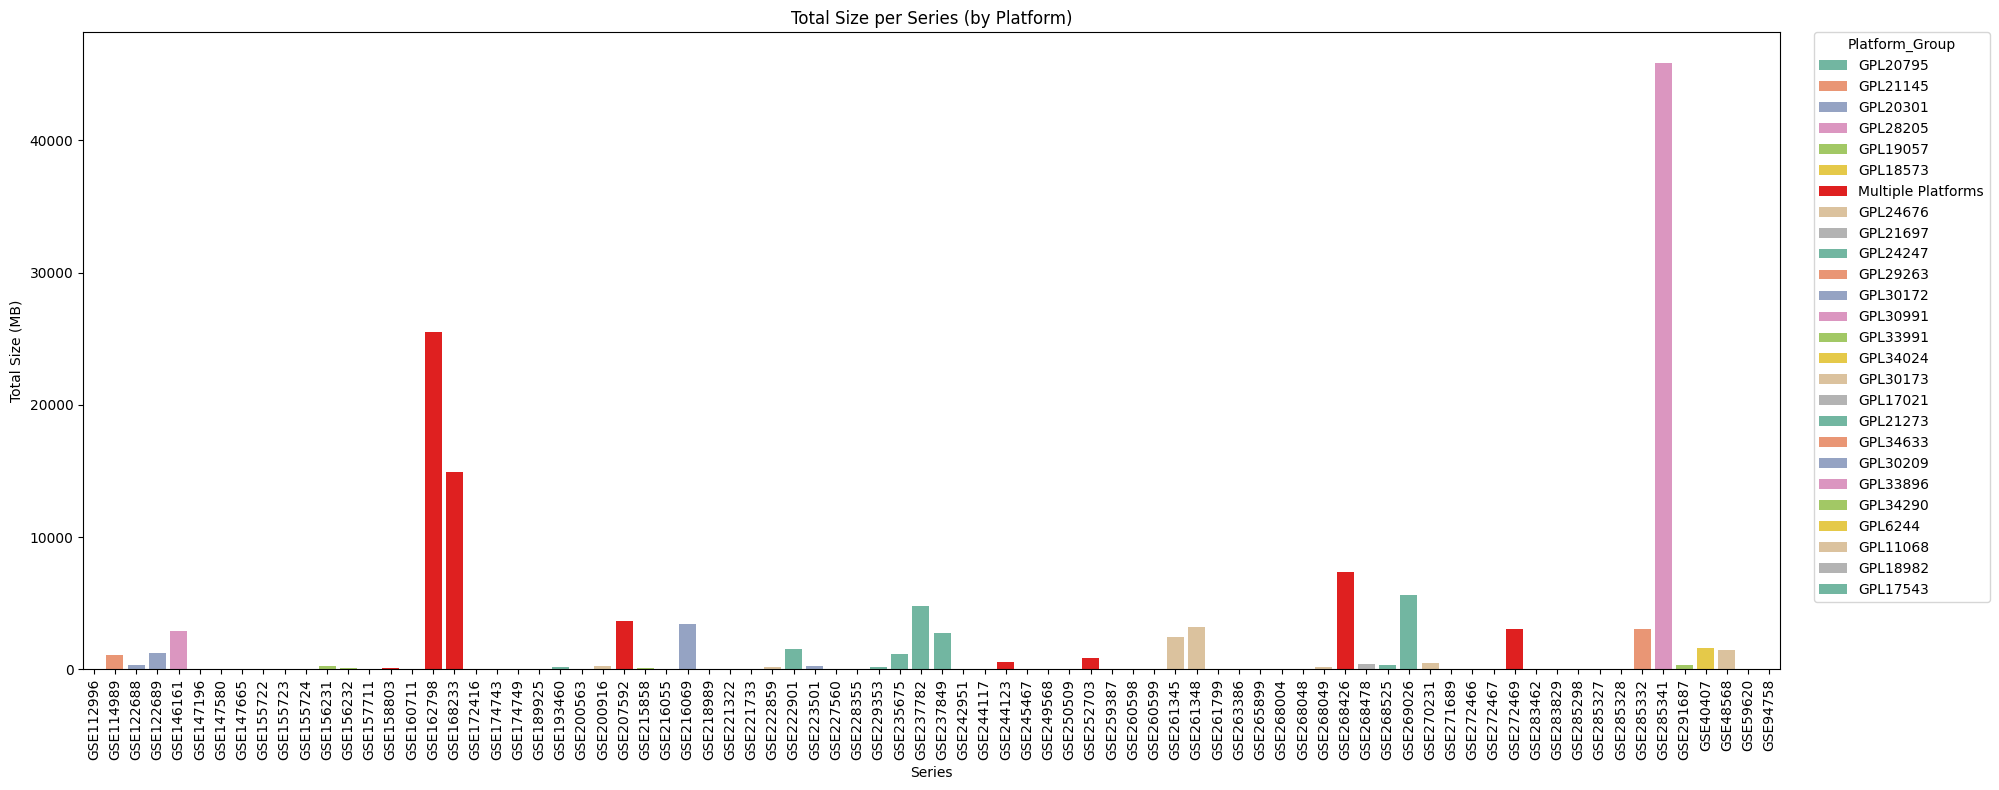

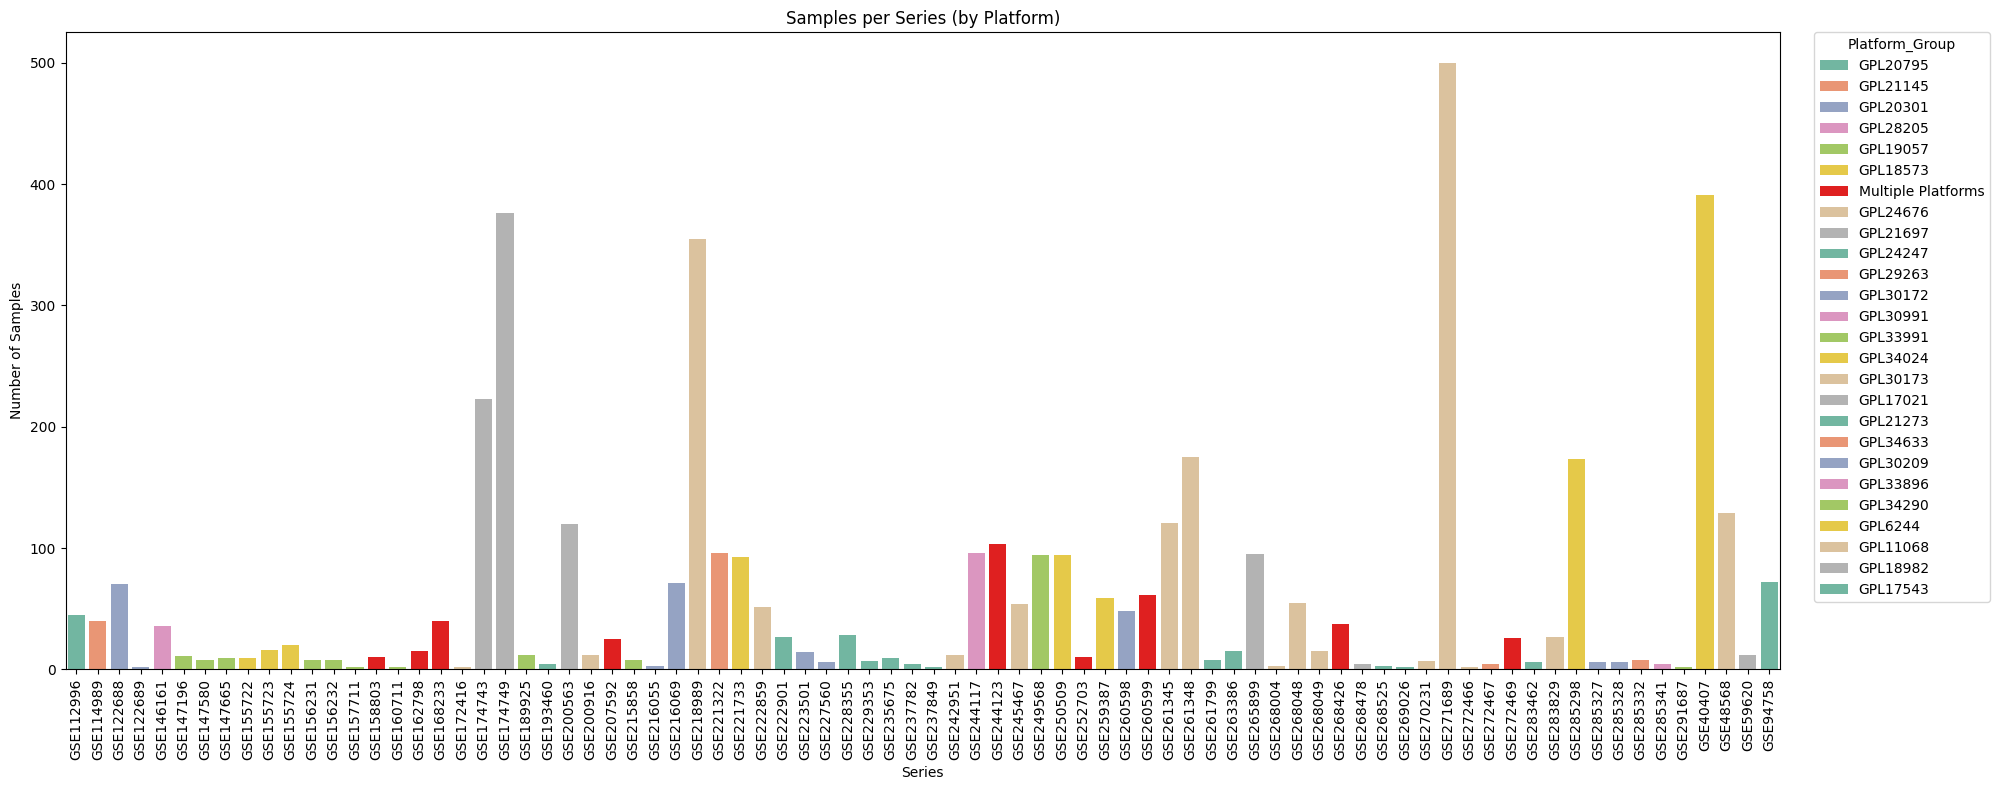

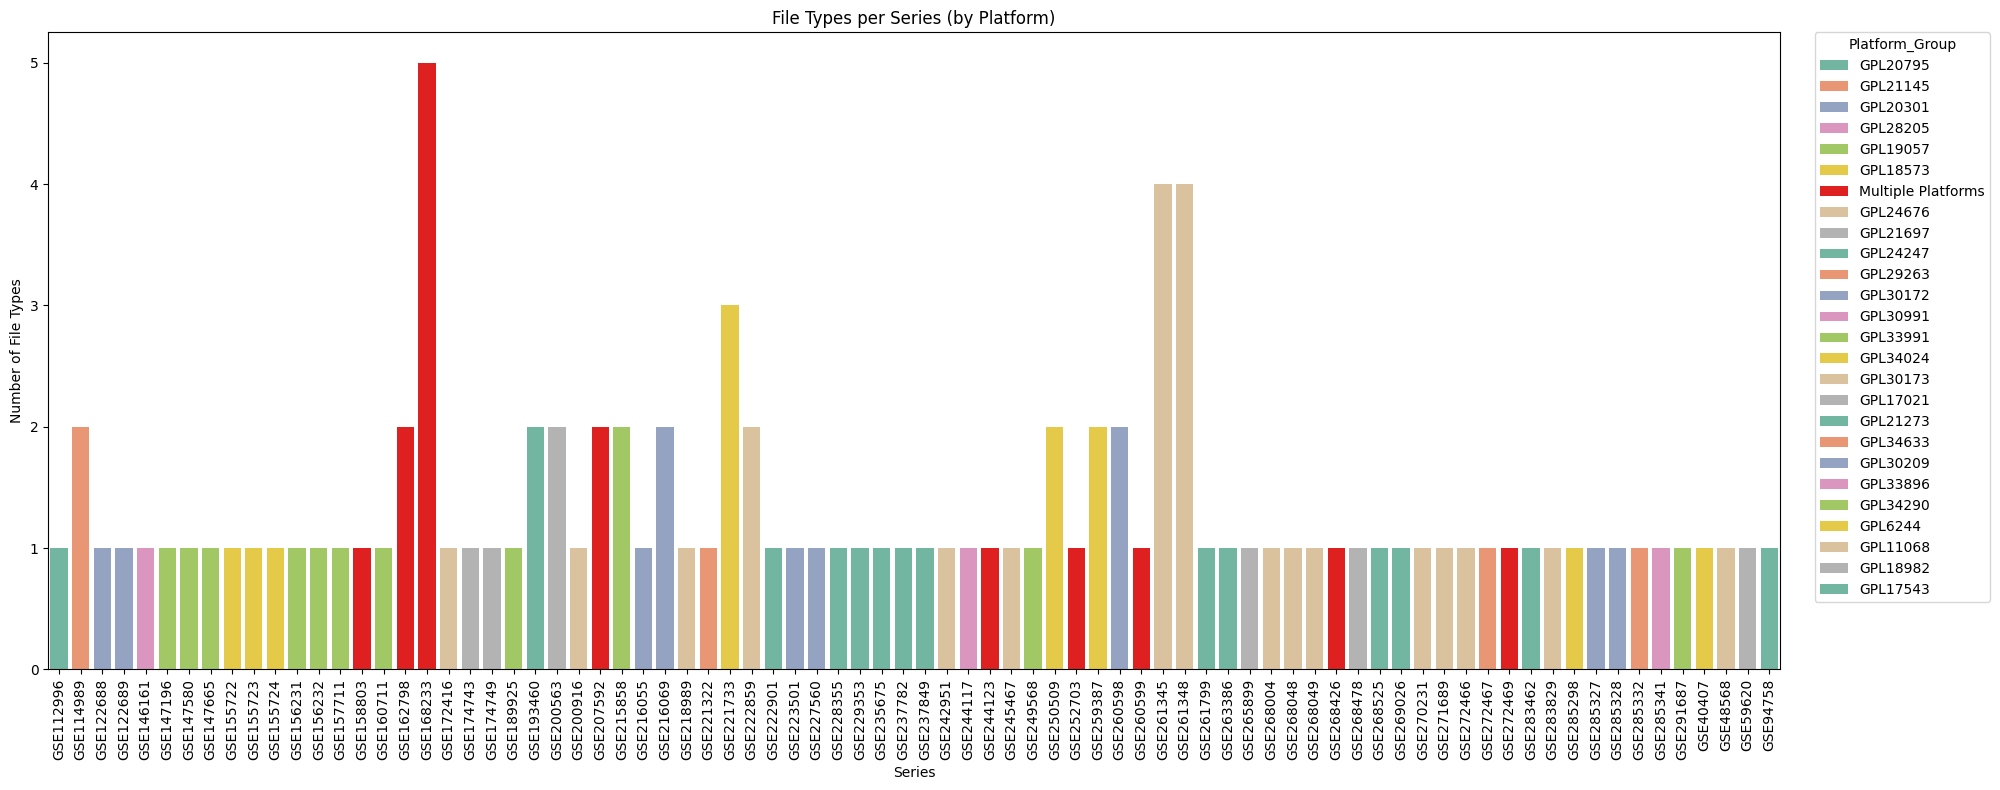

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def size_to_mb(size_str):
    if pd.isnull(size_str):
        return 0
    size_str = str(size_str).strip()
    if not size_str:
        return 0
    try:
        num, unit = size_str.split()
        num = float(num)
        unit = unit.lower()
        if unit.startswith('gb'):
            return num * 1024
        elif unit.startswith('mb'):
            return num
        elif unit.startswith('kb'):
            return num / 1024
        elif unit.startswith('b'):
            return num / (1024 * 1024)
        else:
            return None
    except Exception:
        return None

def unzipped_filetype(filetype):
    if pd.isnull(filetype):
        return filetype
    filetype = str(filetype).strip()
    if filetype.endswith('.gz') and not filetype.endswith('.tar.gz'):
        return filetype[:-3]
    return filetype

def platform_group(platform_str):
    if pd.isnull(platform_str):
        return 'Unknown'
    platforms = [p.strip() for p in str(platform_str).split(',')]
    if len(platforms) > 1:
        return 'Multiple Platforms'
    else:
        return platforms[0]

def dataset_snapshot(
    df,
    series_col='Series',
    samples_col='Samples',
    filetype_col='File type/resource',
    supp_file_col='Supplementary file',
    size_col='Size',
    platforms_col='Platforms',
    multiple_platforms_color='red',
    palette_name='Set2',
    figsize=(12, 6)
):
    """
    Summarize and plot dataset snapshot:
    - Cleans file sizes and file types
    - Groups platform info
    - Plots barplots for total size, samples, file types per Series
    
    Returns:
        summary DataFrame
    """
    # Clean size and file type columns
    df = df.copy()
    df['Size_MB'] = df[size_col].apply(size_to_mb)
    df['Filetype_unzipped'] = df[filetype_col].apply(unzipped_filetype)

    # Summary aggregation
    summary = (
        df
        .groupby(series_col)
        .agg(
            total_size_mb=('Size_MB', 'sum'),
            num_samples=(samples_col, 'first'),
            num_file_types=('Filetype_unzipped', 'nunique'),
            num_files=(supp_file_col, 'nunique'),
            Platforms=(platforms_col, 'first')
        )
        .reset_index()
    )

    summary['Platform_Group'] = summary['Platforms'].apply(platform_group)

    # Palette
    platform_groups = summary['Platform_Group'].unique()
    colors = sns.color_palette(palette_name, len(platform_groups))
    palette = {}
    color_iter = iter(colors)
    for pg in platform_groups:
        if pg == 'Multiple Platforms':
            palette[pg] = multiple_platforms_color
        else:
            palette[pg] = next(color_iter)

    # Plot helper
    def plot_with_outside_legend(data, x, y, hue, palette, ylabel, title):
        plt.figure(figsize=figsize)
        ax = sns.barplot(data=data, x=x, y=y, hue=hue, palette=palette)
        plt.xticks(rotation=90)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()
        plt.legend(
            title=hue,
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            borderaxespad=0.
        )
        plt.show()

    plot_with_outside_legend(
        summary, series_col, 'total_size_mb', 'Platform_Group', palette,
        ylabel='Total Size (MB)', title='Total Size per Series (by Platform)'
    )

    plot_with_outside_legend(
        summary, series_col, 'num_samples', 'Platform_Group', palette,
        ylabel='Number of Samples', title='Samples per Series (by Platform)'
    )

    plot_with_outside_legend(
        summary, series_col, 'num_file_types', 'Platform_Group', palette,
        ylabel='Number of File Types', title='File Types per Series (by Platform)'
    )

    return summary



# # 1. Basic usage
# summary = dataset_snapshot(df_combined)

# # 2. Use a different color for "Multiple Platforms"
# summary = dataset_snapshot(df_combined, multiple_platforms_color='#FF8C00')

# # 3. Use a different palette
# summary = dataset_snapshot(df_combined, palette_name='tab10')

# # 4. Use custom column names (if your DataFrame uses different names)
# summary = dataset_snapshot(
#     df_combined,
#     series_col='GSE_ID',
#     samples_col='SampleCount',
#     filetype_col='FileType',
#     supp_file_col='SuppFile',
#     size_col='FileSize',
#     platforms_col='PlatformInfo'
# )

# 5. Larger plot size for more Series
summary = dataset_snapshot(df_combined, figsize=(18, 8))

## file_per_smp_complexity()


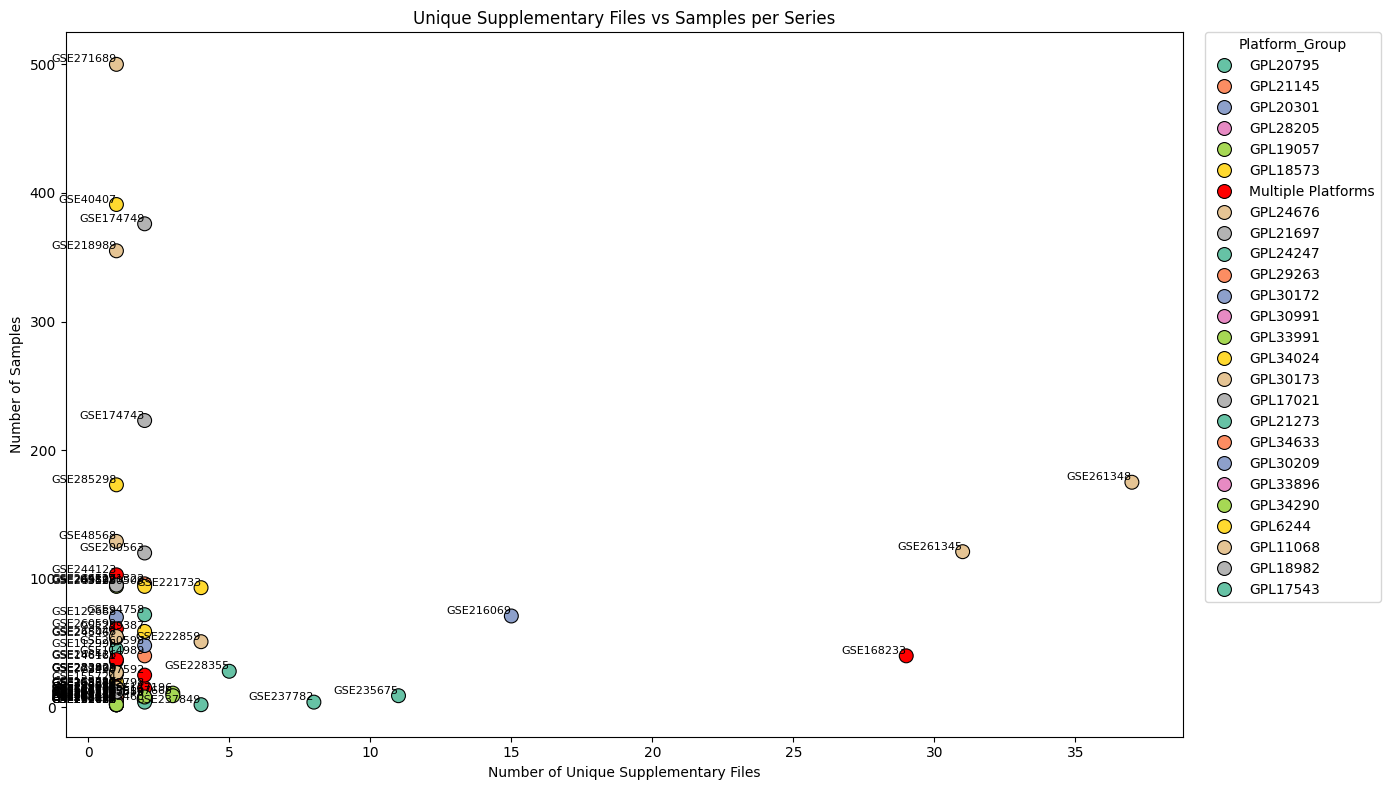

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns

def file_per_smp_complexity(
    summary, 
    palette=None, 
    hue_col='Platform_Group', 
    figsize=(10, 6), 
    label_points=True,
    title='Unique Supplementary Files vs Samples per Series'
):
    """
    Scatter plot showing complexity of each Series:
    - X: Number of unique Supplementary files
    - Y: Number of samples
    - Color: Platform group
    - Labels: Series name
    
    Parameters:
    - summary: DataFrame with columns ['num_files', 'num_samples', 'Series', hue_col]
    - palette: dict or list of colors for hue_col
    - hue_col: column name for hue/color
    - figsize: tuple for figure size
    - label_points: bool, whether to label each point with Series name
    - title: str, plot title
    
    Returns:
    - Displays scatter plot
    """
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(
        data=summary,
        x='num_files',
        y='num_samples',
        hue=hue_col,
        palette=palette,
        s=100,
        edgecolor='k'
    )

    if label_points:
        for i, row in summary.iterrows():
            ax.text(row['num_files'], row['num_samples'], row['Series'], fontsize=8, ha='right', va='bottom')

    plt.xlabel('Number of Unique Supplementary Files')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.legend(
        title=hue_col,
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0.
    )
    plt.tight_layout()
    plt.show()



# # 1. Basic usage
# file_per_smp_complexity(summary, palette=palette)

# # 2. Without point labels
# file_per_smp_complexity(summary, palette=palette, label_points=False)

# # 3. Custom title
# file_per_smp_complexity(summary, palette=palette, title="File Complexity by Series")

# # 4. Use a different hue column (e.g., if you want to color by 'Platforms')
# file_per_smp_complexity(summary, palette=palette, hue_col='Platforms')

# 5. Larger figure size for dense plots
file_per_smp_complexity(summary, palette=palette, figsize=(14, 8))

## file_ext_network()

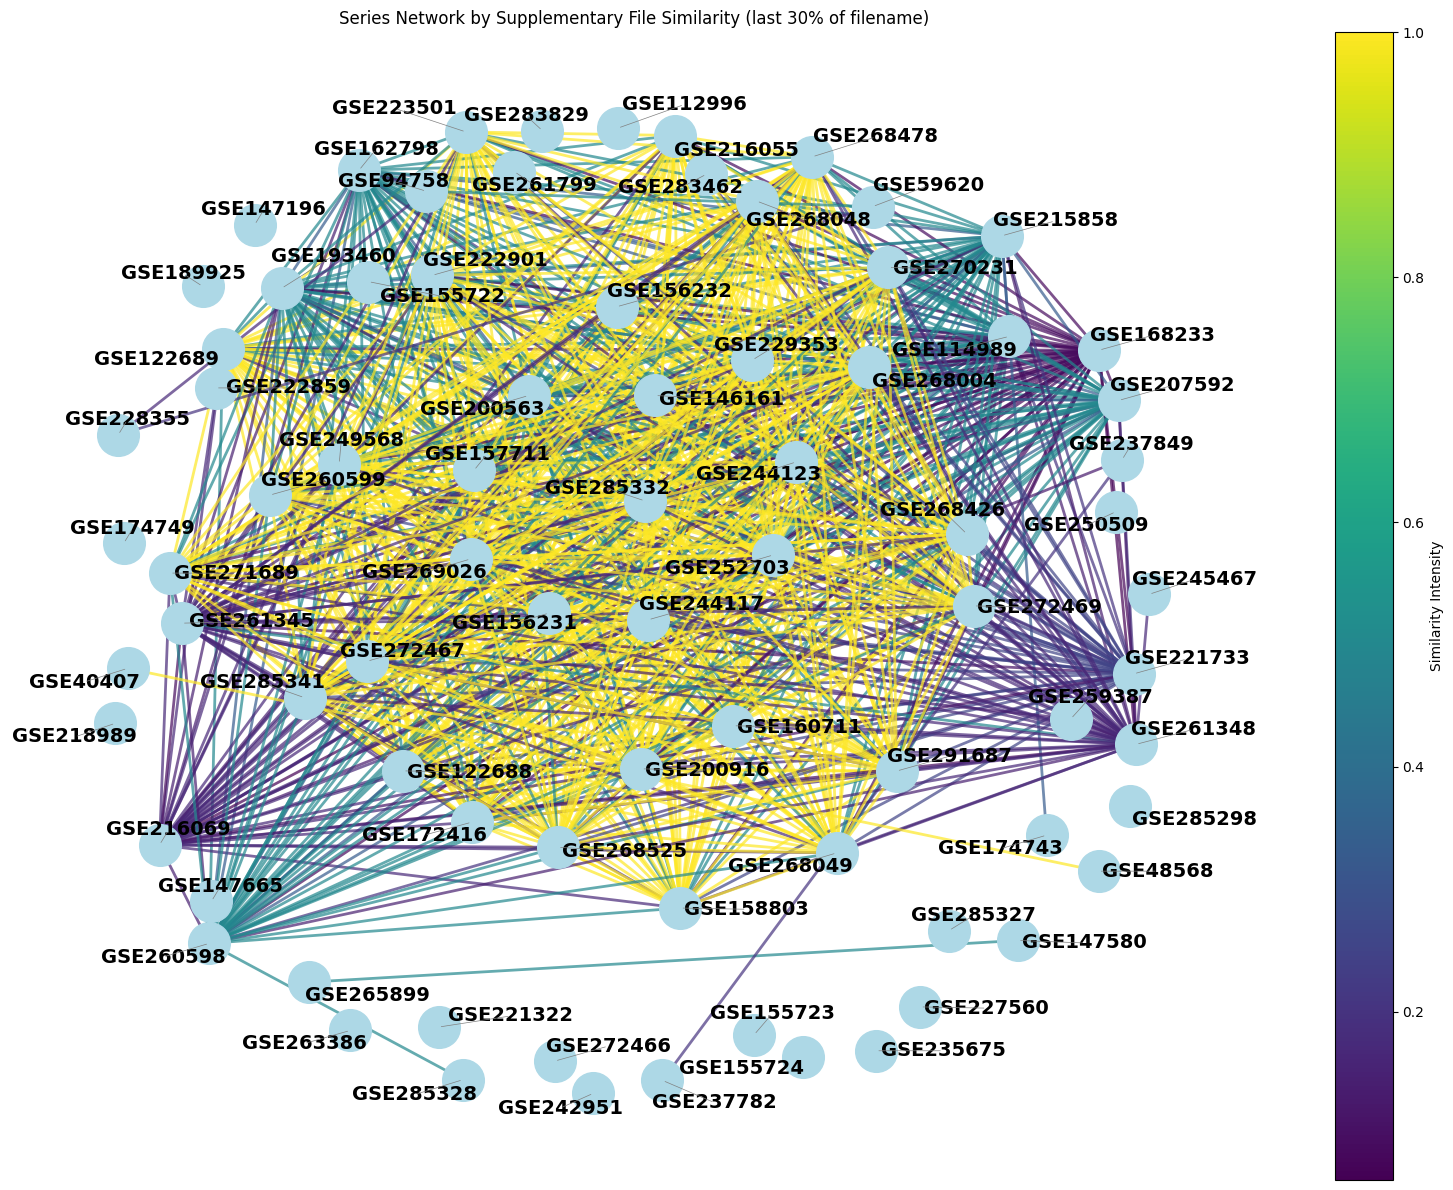

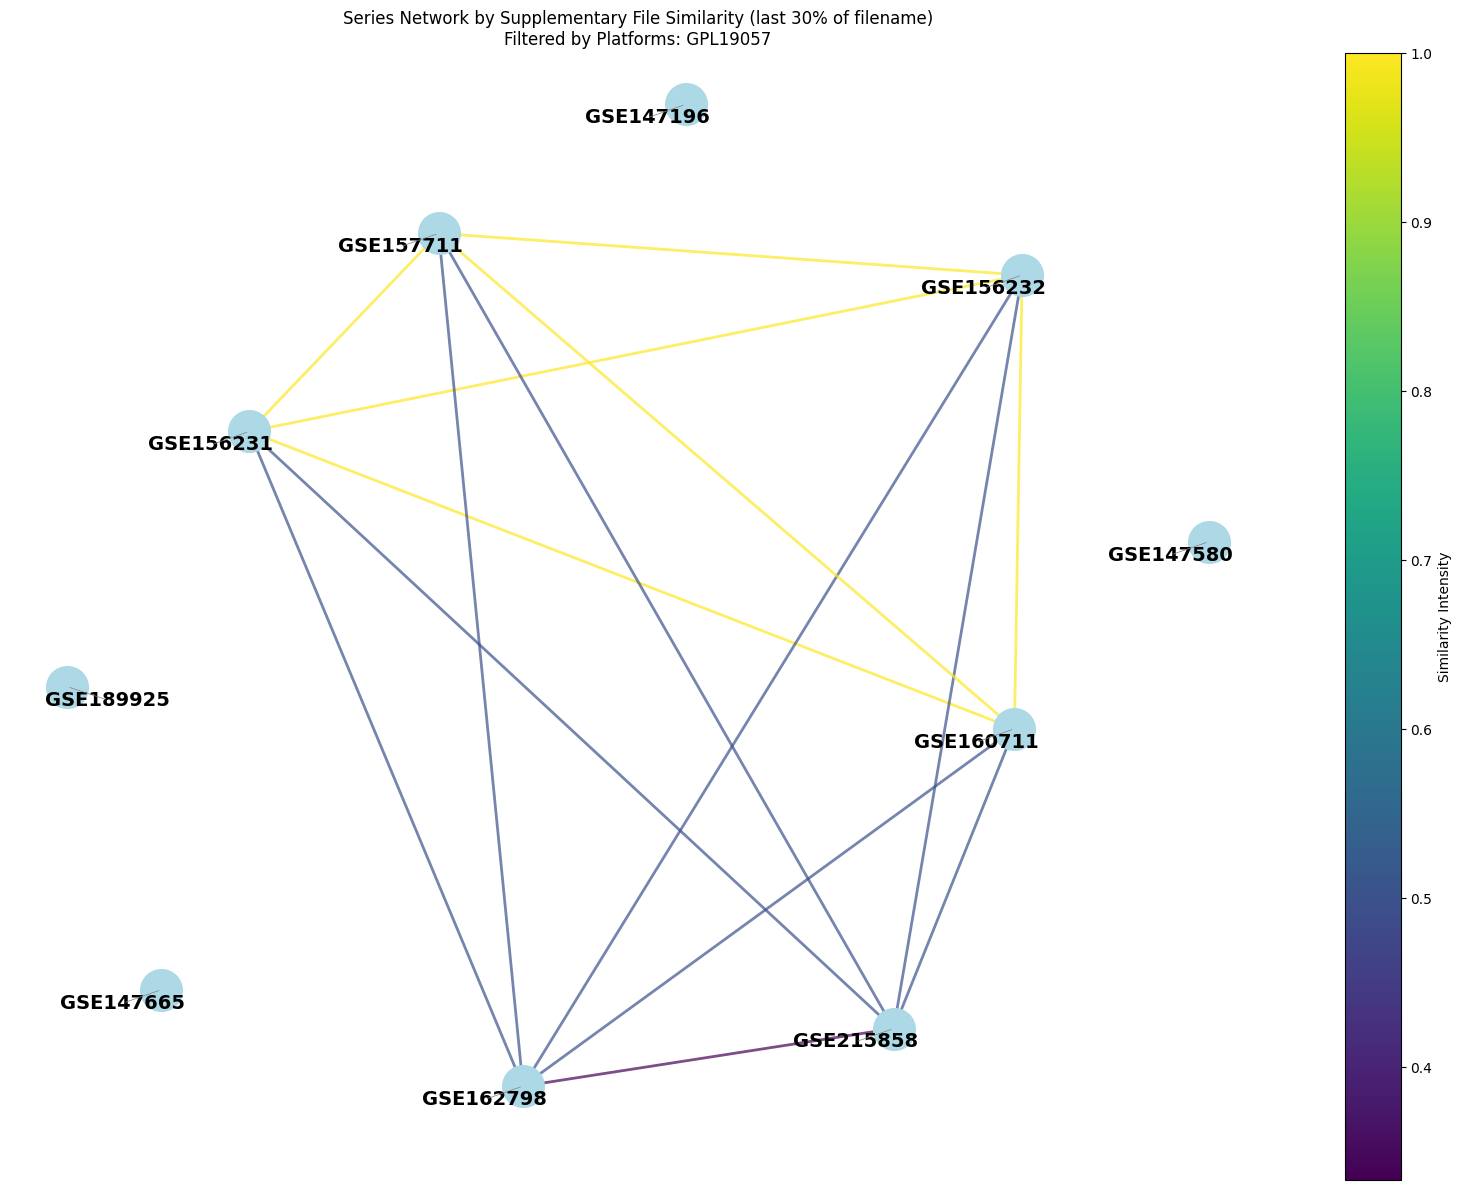

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from adjustText import adjust_text
from itertools import combinations

def file_ext_network(
    df, 
    series_col="Series", 
    supp_file_col="Supplementary file", 
    filter_col=None, 
    filter_val=None, 
    last_pct=0.3, 
    similarity_threshold=0.0, 
    layout='spring', 
    layout_k=2.5, 
    figsize=(16, 12),
    title=None
):
    """
    Build and plot a network of Series based on similarity of the last N% of supplementary file names.
    
    Parameters:
    - df: pandas DataFrame
    - series_col: column name for Series
    - supp_file_col: column name for supplementary files
    - filter_col: column to filter by (e.g., 'Platforms'), or None
    - filter_val: value or substring to filter for in filter_col
    - last_pct: percentage (0-1) of string from the end to use for similarity
    - similarity_threshold: minimum similarity to create an edge (0 for all)
    - layout: 'spring' or 'kamada_kawai'
    - layout_k: spring_layout k parameter (ignored if layout != 'spring')
    - figsize: figure size tuple
    - title: plot title (default: auto-generated)
    """
    # Optional filtering
    df_net = df.copy()
    if filter_col and filter_val:
        df_net = df_net[df_net[filter_col].str.contains(filter_val, na=False)]
        if df_net.empty:
            print(f"No data after filtering {filter_col} for '{filter_val}'")
            return

    # Helper for last N% of string
    def last_pct_str(s, pct=last_pct):
        if pd.isnull(s):
            return ''
        s = str(s)
        n = max(1, int(len(s) * pct))
        return s[-n:]

    # Build sets of file endings per Series
    series_files = (
        df_net
        .groupby(series_col)[supp_file_col]
        .apply(lambda files: set(last_pct_str(f) for f in files))
    )

    # Calculate similarities
    edges = []
    for s1, s2 in combinations(series_files.index, 2):
        set1 = series_files[s1]
        set2 = series_files[s2]
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        similarity = intersection / union if union else 0
        if similarity > similarity_threshold:
            edges.append((s1, s2, similarity))

    # Build graph
    G = nx.Graph()
    for s in series_files.index:
        G.add_node(s)
    for s1, s2, sim in edges:
        G.add_edge(s1, s2, weight=sim)

    # Layout
    if layout == 'spring':
        pos = nx.spring_layout(G, seed=42, k=layout_k)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        raise ValueError("layout must be 'spring' or 'kamada_kawai'")

    # Edge colors
    edges_draw = G.edges(data=True)
    weights = [d['weight'] for (_, _, d) in edges_draw]
    if weights:
        weights_arr = np.array(weights)
        norm_weights = (weights_arr - weights_arr.min()) / (weights_arr.max() - weights_arr.min() + 1e-10)
        edge_colors = plt.cm.viridis(norm_weights)
    else:
        edge_colors = []

    # Plot
    plt.figure(figsize=figsize)
    ax = plt.gca()
    nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors, ax=ax, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, node_size=900, node_color='lightblue', ax=ax)

    # Adjusted labels
    texts = []
    for node, (x, y) in pos.items():
        texts.append(plt.text(x, y, node, fontsize=14, fontweight='bold', ha='center', va='center'))

    adjust_text(texts, 
                expand_points=(2.5, 2.5), 
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Colorbar
    if weights:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=weights_arr.min(), vmax=weights_arr.max()))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Similarity Intensity')

    # Title
    if not title:
        title = f"{series_col} Network by Supplementary File Similarity (last {int(last_pct*100)}% of filename)"
        if filter_col and filter_val:
            title += f"\nFiltered by {filter_col}: {filter_val}"
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Usage examples
# 1. Basic usage (all Series)
file_ext_network(df_combined)

# 2. Filter by Platform
file_ext_network(df_combined, filter_col="Platforms", filter_val="GPL19057")

# # 3. Use a different layout and tighter similarity threshold
# file_ext_network(
#     df_combined, 
#     filter_col="Platforms", 
#     filter_val="GPL19057",
#     layout='kamada_kawai',
#     similarity_threshold=0.1
# )

# # 4. Use a different percentage of filename for similarity
# file_ext_network(df_combined, last_pct=0.5)  # Use last 50% of filename

# # 5. Custom plot title
# file_ext_network(
#     df_combined, 
#     filter_col="Platforms", 
#     filter_val="GPL19057",
#     title="My Custom Network Plot"
# )